# **TR-2021/XX - Technical report: Use of LSTM models to predict daily maximum temperature**

|Technical Report ID  |2021/XX|
|--|--|
| Title | Use of LSTM models to predict daily maximum temperature|
| Authors | Guilherme Lisboa, Paula Dornhofer|
| Creation Date| 2021 - july|


**DESCRIPTION**: 

This notebook was created to describe the use of an LSTM model in IAC database to predict the daily maximum temperature in the city of Campinas, São Paulo, Brazil, was used data from 2000 to 2018, the last two years are separated for tests.

**TUTORIAL**
https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

##**Library and import drive**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
import seaborn as sns
from numpy import concatenate
import statistics

#keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#import py file with funtions from drive
import sys
import os

#Import Climatex. - version not att. 
! git clone https://github.com/climate-and-health-datasci-Unicamp/py-climate-health-toolbox
import sys
sys.path.append('/content/py-climate-health-toolbox/climahe')
import climatex as tex
#=======================

#google files
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Cloning into 'py-climate-health-toolbox'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 142 (delta 70), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (142/142), 7.88 MiB | 10.79 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Mounted at /content/drive


##**Defining funciton (from the tutorial)**


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  import pandas as pd
  #identifica a quantidade de variaveis do dataset
  n_vars = 1 if type(data) is list else data.shape[1]
  #transforma em dataframe pandas
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1). Quantidade de lags antes do tempo t
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n). Quantidade de lags depois do tempo t
    '''
  É esse o argumento da função que alteraremos quando for usar, caso adotemos
  a previsão para 2 dias ou mais na frente. O padrão está como 
  previsão do tempo (t) --> n_out=1, que foi o utilizado pelo Jason.
    '''
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

##**Preparing the dataset**


In [ ]:
#load data
df_vir = pd.read_csv('/content/drive/Shareddrives/Clima&Saúde/Dados/Dados_Clima/IAC/data/processed/IAC_HW1956_2018.csv')
df_vir = df_vir.drop(columns = {'Unnamed: 0'})
df_vir['DATE'] = pd.to_datetime(df_vir['DATE'])
df_vir['YEAR'] = df_vir['DATE'].dt.year
df_vir
#Using for year >= 2000
df = df_vir[df_vir['YEAR']>=2000]
df

DAY365       DATE  YEAR  ...  N_AIRTMP_MIN  above_pct  HW
16060       1 2000-01-01  2000  ...          20.0          0   0
16061       2 2000-01-02  2000  ...          19.8          0   0
16062       3 2000-01-03  2000  ...          18.2          0   0
16063       4 2000-01-04  2000  ...          19.2          0   0
16064       5 2000-01-05  2000  ...          20.0          0   0
...       ...        ...   ...  ...           ...        ...  ..
22990     361 2018-12-27  2018  ...          19.0          0   0
22991     362 2018-12-28  2018  ...          18.6          0   0
22992     363 2018-12-29  2018  ...          18.7          0   0
22993     364 2018-12-30  2018  ...          19.8          0   0
22994     365 2018-12-31  2018  ...          19.0          0   0

[6935 rows x 8 columns]

In [ ]:
#checar NAN
print('NAN count:\n')
print(np.sum(df.isnull()))


NAN count:

DAY365          0
DATE            0
YEAR            0
N_RAIN_TOT      0
N_AIRTMP_MAX    1
N_AIRTMP_MIN    0
above_pct       0
HW              0
dtype: int64


In [ ]:
#Climatex Function (Using all years to climatic normal)

dataset, df_pct = tex.check_HeatWave(df, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN', df_vir, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN')


In [ ]:
df = dataset
#Transform DATE in datetime format and create MONTH variable
df['DATE'] = pd.to_datetime(df['DATE'])

#set datetime index
df.set_index(df['DATE'],inplace=True)
#Y being the response variable
df['y'] = df['HW']
df = df.drop(columns=['HW','DAY365','DATE','YEAR'])

#Fill nan with mean values
df['N_AIRTMP_MAX'].fillna(df['N_AIRTMP_MAX'].mean(), inplace=True)

#checking NAN again
print('NAN count:\n')
print(np.sum(df.isnull()))

df.head()

NAN count:

N_RAIN_TOT      0
N_AIRTMP_MAX    0
N_AIRTMP_MIN    0
above_pct       0
y               0
dtype: int64


N_RAIN_TOT  N_AIRTMP_MAX  N_AIRTMP_MIN  above_pct  y
DATE                                                            
2000-01-01        71.5          26.8          20.0          0  0
2000-01-02        24.3          25.0          19.8          0  0
2000-01-03        13.7          24.8          18.2          0  0
2000-01-04         6.6          24.8          19.2          0  0
2000-01-05        17.4          24.8          20.0          0  0

HWN   HWD   HWF
YEAR                 
2000  0.0   0.0   0.0
2001  1.0   3.0   3.0
2002  4.0  10.0  21.0
2003  2.0   3.0   6.0
2004  2.0   5.0   8.0
2005  2.0   5.0   8.0
2006  2.0   3.0   6.0
2007  1.0   6.0   6.0
2008  0.0   0.0   0.0
2009  0.0   0.0   0.0
2010  0.0   0.0   0.0
2011  0.0   0.0   0.0
2012  1.0   4.0   4.0
2013  0.0   0.0   0.0
2014  5.0  11.0  25.0
2015  6.0   8.0  27.0
2016  1.0   8.0   8.0
2017  2.0   4.0   7.0
2018  1.0   4.0   4.0

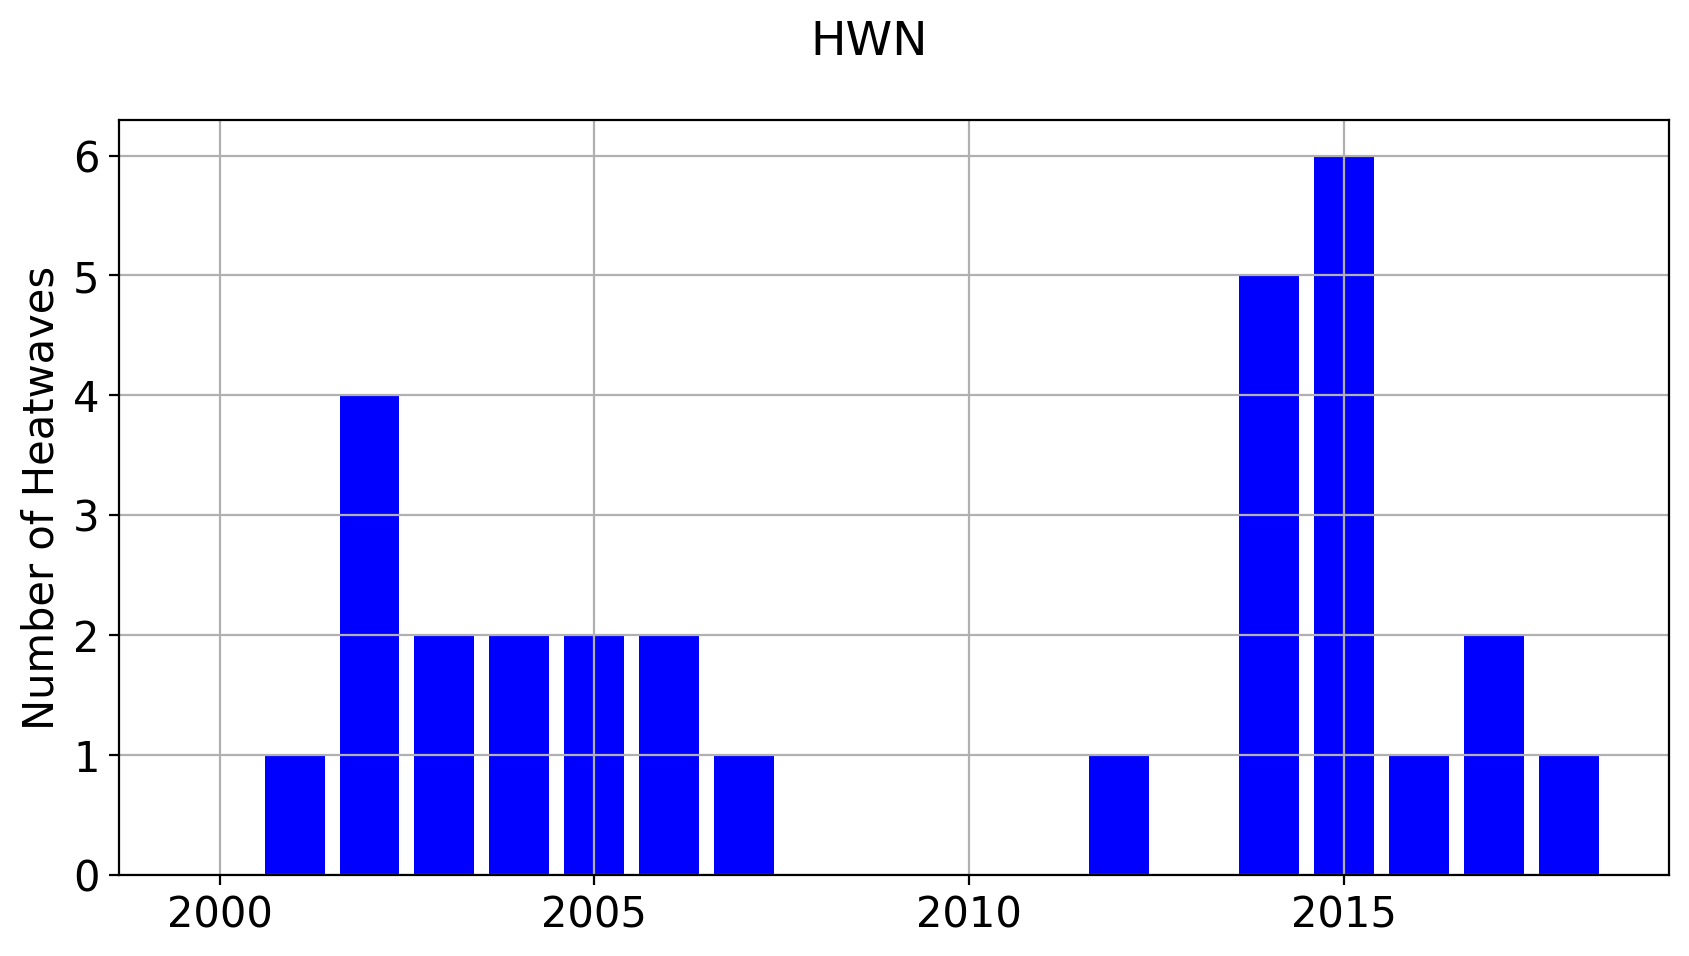

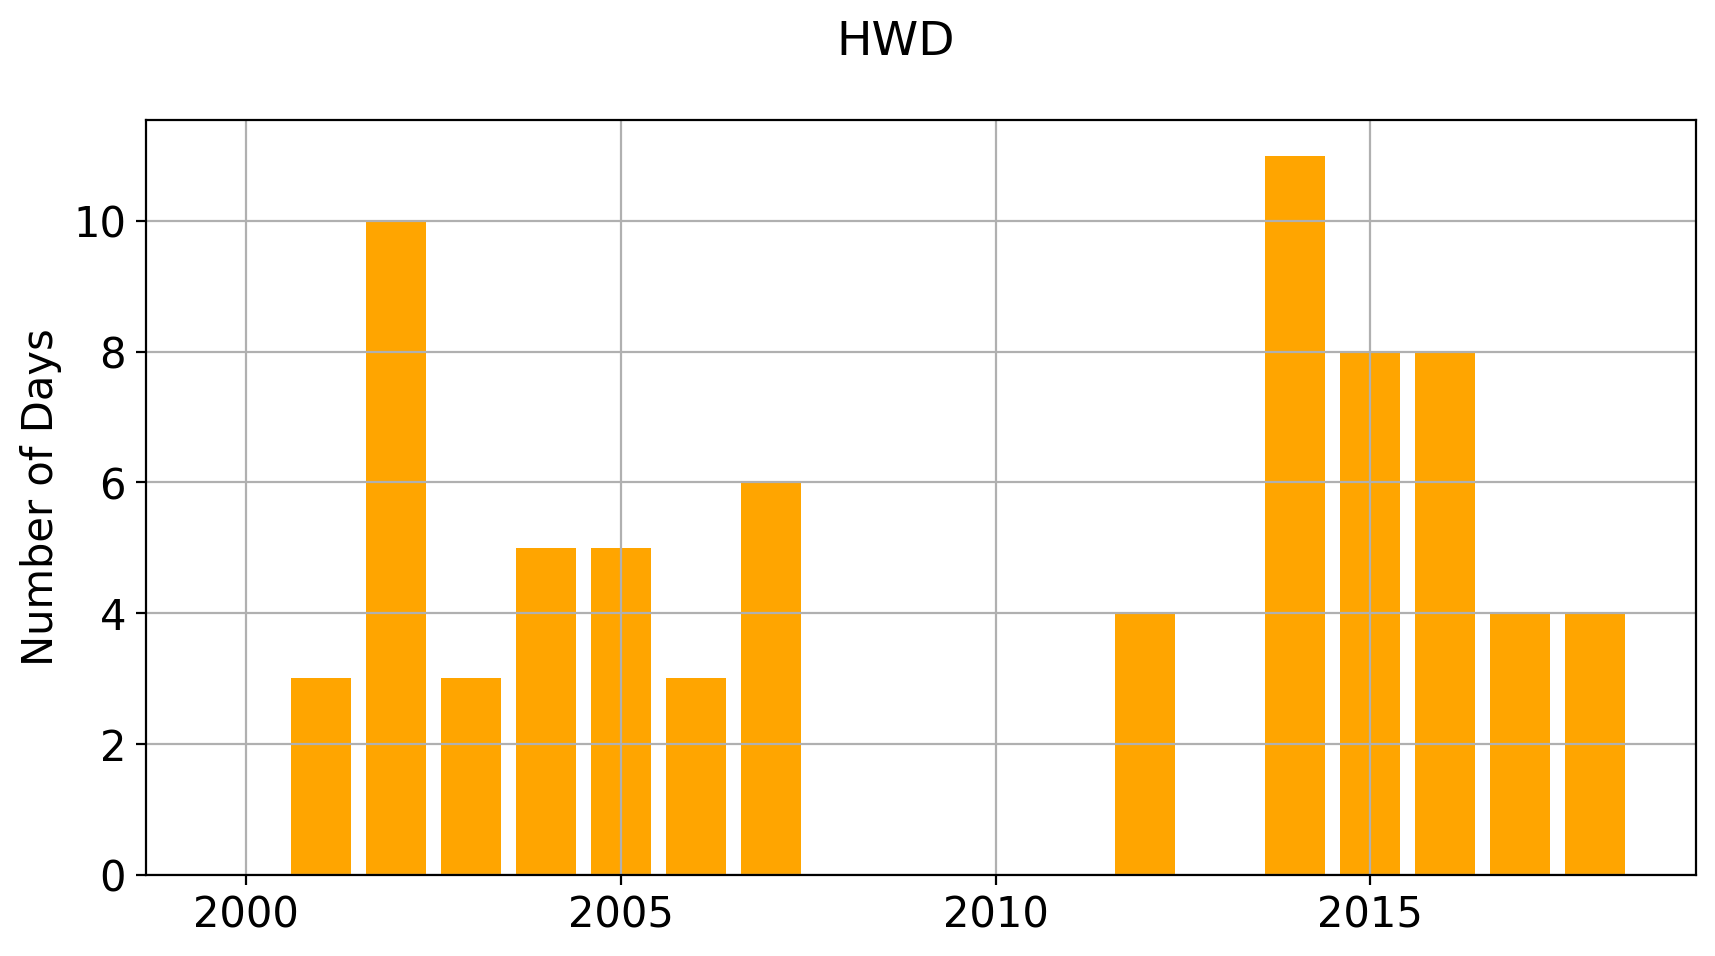

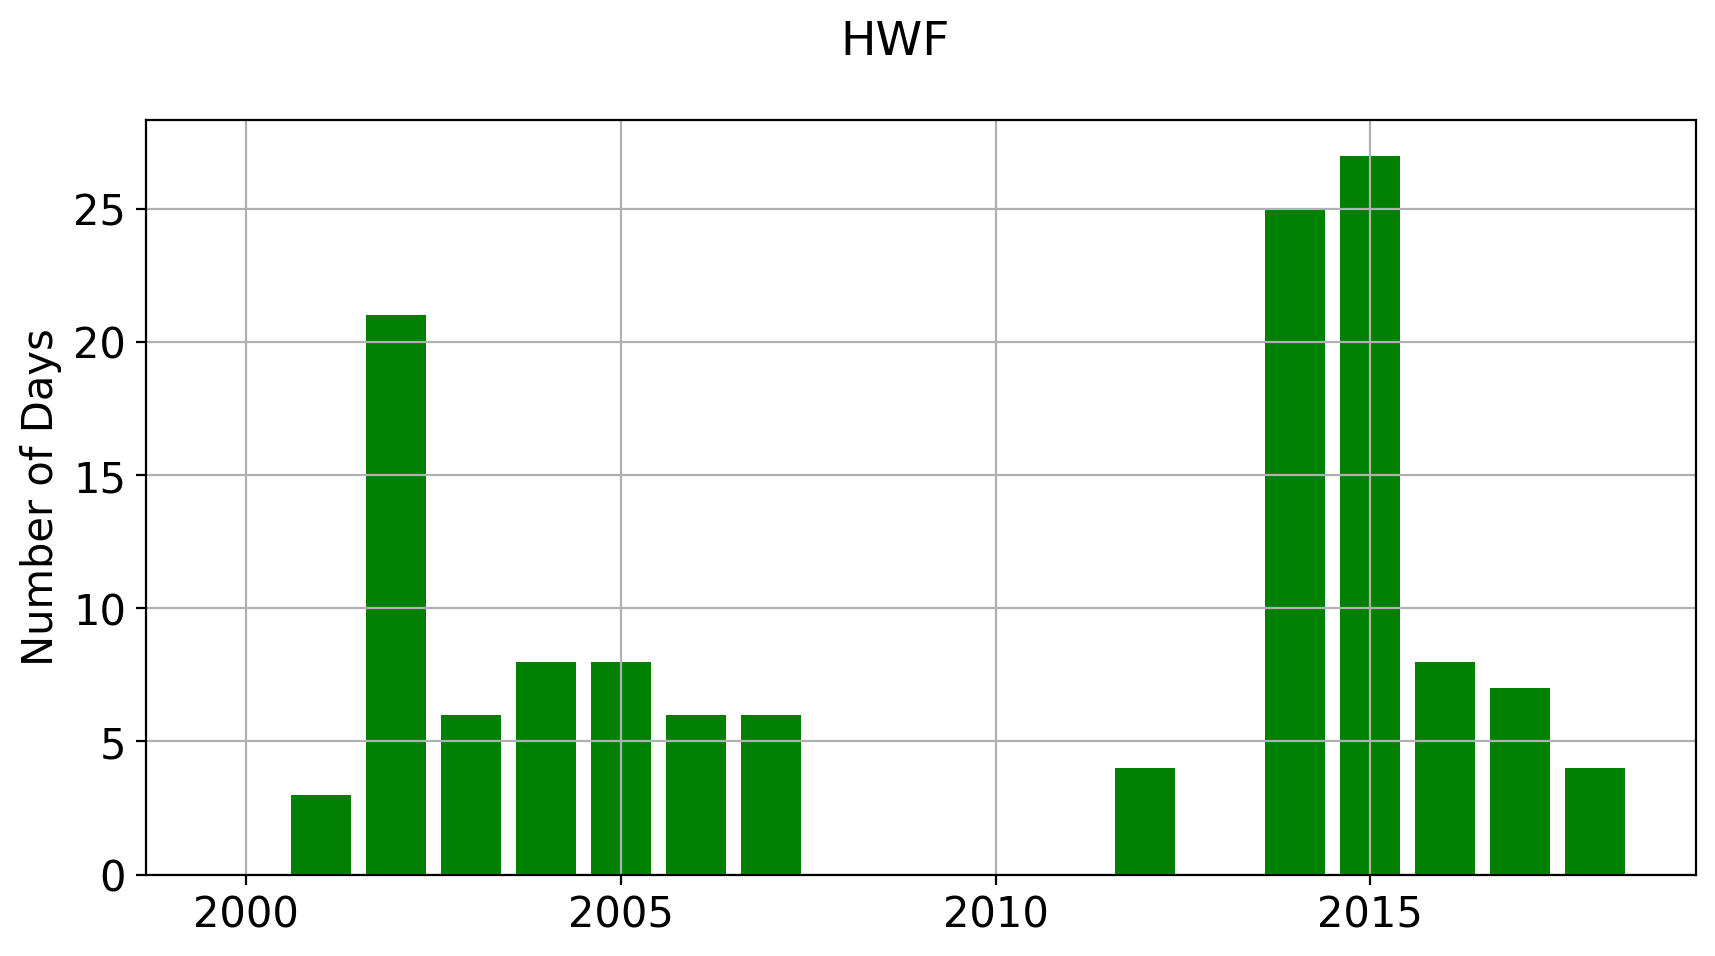

In [ ]:
metric_total = tex.wave_metrics(dataset, 'HW', True)
df_metrics_teste = df_vir[df_vir['YEAR']>=2014]
sum(df_metrics_teste['above_pct'])
metric_total



##**Series_to_supervised**

In [ ]:
#######     train     ############

n_train_days = 365 * 17 #2000 to 2016


#df_train contains the train values

df_train = df.iloc[:n_train_days, :]
df_train = df_train.drop(columns=['above_pct','y','N_RAIN_TOT'])
print(df_train.head(3))
values_train = df_train.values

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(values_train)
print(scaled_train[:5,:])
# specify the number of lag (days in this case, since each line equals a day)
n_days = 4
#TROCAR AQUI PARA DAYS_AHEAD = 1
days_ahead = 7
n_features = values_train.shape[1]

reframed_train = series_to_supervised(scaled_train, n_days, days_ahead)
train = reframed_train
print(train.head(5))
train = train.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2000-01-01          26.8          20.0
2000-01-02          25.0          19.8
2000-01-03          24.8          18.2
[[0.56766917 0.78632479]
 [0.5        0.77777778]
 [0.4924812  0.70940171]
 [0.4924812  0.75213675]
 [0.4924812  0.78632479]]
   var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t+5)  var1(t+6)  var2(t+6)
4   0.567669   0.786325   0.500000  ...   0.777778   0.748120   0.743590
5   0.500000   0.777778   0.492481  ...   0.743590   0.695489   0.794872
6   0.492481   0.709402   0.492481  ...   0.794872   0.748120   0.777778
7   0.492481   0.752137   0.492481  ...   0.777778   0.755639   0.829060
8   0.492481   0.786325   0.687970  ...   0.829060   0.770677   0.811966

[5 rows x 22 columns]


In [ ]:
#######    test      ############

#df_test contains the test values
df_test = df.iloc[n_train_days:, :]
df_test = df_test.drop(columns=['above_pct',	'y','N_RAIN_TOT'])
print(df_test)
values_test = df_test.values
# ensure all data is float
np.set_printoptions(suppress=True) #supress scientific notation
values_test = values_test.astype('float32')
# normalize features
scaled_test = scaler_train.transform(values_test)

# specify the number of lag (days in this case, since each line equals a day)

n_features = values_test.shape[1]
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, n_days, days_ahead)
test = reframed_test
print(test)
test = test.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2017-01-01          31.2          20.4
2017-01-02          31.8          19.9
2017-01-03          31.5          21.5
2017-01-04          34.5          21.0
2017-01-05          29.5          21.0
...                  ...           ...
2018-12-27          28.8          19.0
2018-12-28          31.2          18.6
2018-12-29          31.7          18.7
2018-12-30          32.1          19.8
2018-12-31          33.5          19.0

[730 rows x 2 columns]
     var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t+5)  var1(t+6)  var2(t+6)
4     0.733083   0.803419   0.755639  ...   0.799145   0.706767   0.790598
5     0.755639   0.782051   0.744361  ...   0.790598   0.729323   0.833333
6     0.744361   0.850427   0.857143  ...   0.833333   0.578947   0.747863
7     0.857143   0.829060   0.669173  ...   0.747863   0.654135   0.756410
8     0.669173   0.829060   0.721804  ...   0.756410   0.755639   0.752137
..         ...     

In [ ]:
n_obs = n_days * n_features

#Train and test

#response being the -2 colune, the temp max at day t +6
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input (train_X and test_X) to be 3D [SAMPLES, TIMESTEPS, FEATURES]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6195, 8) 6195 (6195,)
(6195, 4, 2) (6195,) (720, 4, 2) (720,)


## **Modeling**

Epoch 1/170
42/42 - 3s - loss: 0.1058 - val_loss: 0.0105
Epoch 2/170
42/42 - 0s - loss: 0.0121 - val_loss: 0.0100
Epoch 3/170
42/42 - 0s - loss: 0.0117 - val_loss: 0.0097
Epoch 4/170
42/42 - 0s - loss: 0.0114 - val_loss: 0.0095
Epoch 5/170
42/42 - 0s - loss: 0.0111 - val_loss: 0.0093
Epoch 6/170
42/42 - 0s - loss: 0.0109 - val_loss: 0.0092
Epoch 7/170
42/42 - 0s - loss: 0.0108 - val_loss: 0.0091
Epoch 8/170
42/42 - 0s - loss: 0.0107 - val_loss: 0.0091
Epoch 9/170
42/42 - 0s - loss: 0.0107 - val_loss: 0.0091
Epoch 10/170
42/42 - 0s - loss: 0.0107 - val_loss: 0.0092
Epoch 11/170
42/42 - 0s - loss: 0.0107 - val_loss: 0.0092
Epoch 12/170
42/42 - 0s - loss: 0.0107 - val_loss: 0.0092
Epoch 13/170
42/42 - 0s - loss: 0.0107 - val_loss: 0.0092
Epoch 14/170
42/42 - 0s - loss: 0.0106 - val_loss: 0.0092
Epoch 15/170
42/42 - 0s - loss: 0.0106 - val_loss: 0.0092
Epoch 16/170
42/42 - 0s - loss: 0.0106 - val_loss: 0.0092
Epoch 17/170
42/42 - 0s - loss: 0.0106 - val_loss: 0.0092
Epoch 18/170
42/42 - 0s

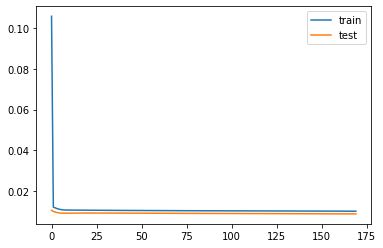

In [ ]:
#ORIGINAL

# design network
model = Sequential()
model.add(LSTM(70,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='nadam')

# fit network
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', patience=170,verbose=0)
callbacks_list = [stop]

history = model.fit(train_X, train_y, epochs=170, batch_size=150, callbacks = callbacks_list, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat1 = model.predict(test_X)
#Reshape test_X to get 7 random columns
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70)                20440     
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 20,511
Trainable params: 20,511
Non-trainable params: 0
_________________________________________________________________
None 

n atrasos =  4 dias
Test RMSE: 2.493


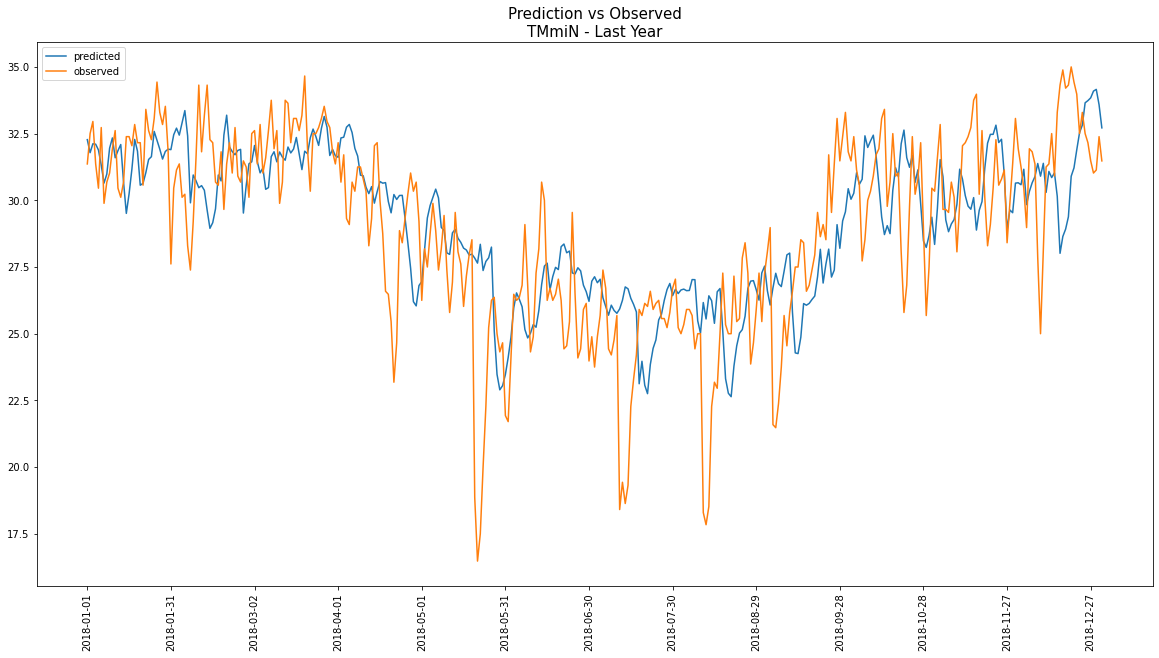

In [ ]:
#attention, scale function

inv_param = -1*(n_features-1)
# invert scaling for forecast
inv_yhat1 = concatenate((yhat1, test_X[:, inv_param:]), axis=1)
inv_yhat1 = scaler_train.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]


# invert scaling for actual


#Scale function
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, inv_param:]), axis=1)
inv_y = scaler_train.inverse_transform(inv_y)
inv_y = inv_y[:,0]



# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat1))
print(model.summary(),'\n')
print('n atrasos = ',n_days,'dias')
print('Test RMSE: %.3f' % rmse)



# plot time series
ts_size = 365 #how many days from the end do you wanna see?
interval = 30 #days invterval for x ticks

plt.figure(figsize=[20,10])
plt.plot(inv_yhat1[-ts_size:], label='predicted')
plt.plot(inv_y[-ts_size:], label='observed')
plt.title('Prediction vs Observed\nTMmiN - Last Year',fontsize=15)
dates = df.index[-ts_size:-1].date
ticks = []
for i in list(range(0,len(dates),interval)):
  ticks.append(dates[i])
plt.xticks(range(0, ts_size,interval),ticks,rotation=90)
plt.legend()
plt.show()

##**checking the results**

In [ ]:
#Create a new data frane for max_pred
temp_pred = pd.DataFrame()
temp_pred['max_pred'] = inv_yhat1
temp_pred
temp_pred['DATE'] = df.index[n_train_days + n_days + days_ahead -1 :]
df_merge_col = pd.merge(temp_pred, df, on='DATE')
df_merge_col = df_merge_col.drop(columns=['above_pct', 'y'])


#Climatex for temp_pred
#Using the same normal climatic and real temp min to check max_temp_pred performance
pred_above, df_pct_b = tex.check_HeatWave(df_merge_col, 'max_pred', 'N_AIRTMP_MAX', df_vir, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN')
pred_above = pred_above.drop(columns=['N_RAIN_TOT'])
pred_above = pd.merge(pred_above, df_pct, on='DAY365')
pred_above = pred_above.sort_values(by='DATE')
pred_above.head(15)

DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
0        1 2017-01-01        NaN  ...   0     32.60      20.8
2        2 2017-01-02        NaN  ...   0     32.60      20.8
4        3 2017-01-03        NaN  ...   0     32.70      20.8
6        4 2017-01-04        NaN  ...   0     32.70      20.8
8        5 2017-01-05        NaN  ...   0     32.70      20.8
10       6 2017-01-06        NaN  ...   0     32.70      20.8
12       7 2017-01-07        NaN  ...   0     32.70      21.0
14       8 2017-01-08        NaN  ...   0     32.70      21.0
16       9 2017-01-09        NaN  ...   0     32.77      21.0
18      10 2017-01-10        NaN  ...   0     32.80      21.0
20      11 2017-01-11  33.409935  ...   0     32.80      21.0
22      12 2017-01-12  32.746830  ...   0     32.90      21.0
24      13 2017-01-13  33.259129  ...   1     32.90      21.0
26      14 2017-01-14  33.052002  ...   1     33.00      21.0
28      15 2017-01-15  33.459301  ...   1     33.00      21.0

[15 rows x 9 columns]

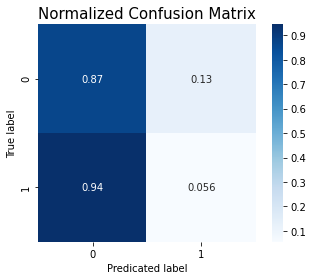

In [ ]:
cm2 = confusion_matrix(df_vir[df_vir['YEAR']>=2017]['above_pct'], pred_above['above_pct'],normalize='true')
sns.heatmap(cm2, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 15)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

[texto do link](https://)##**Making a graphic **

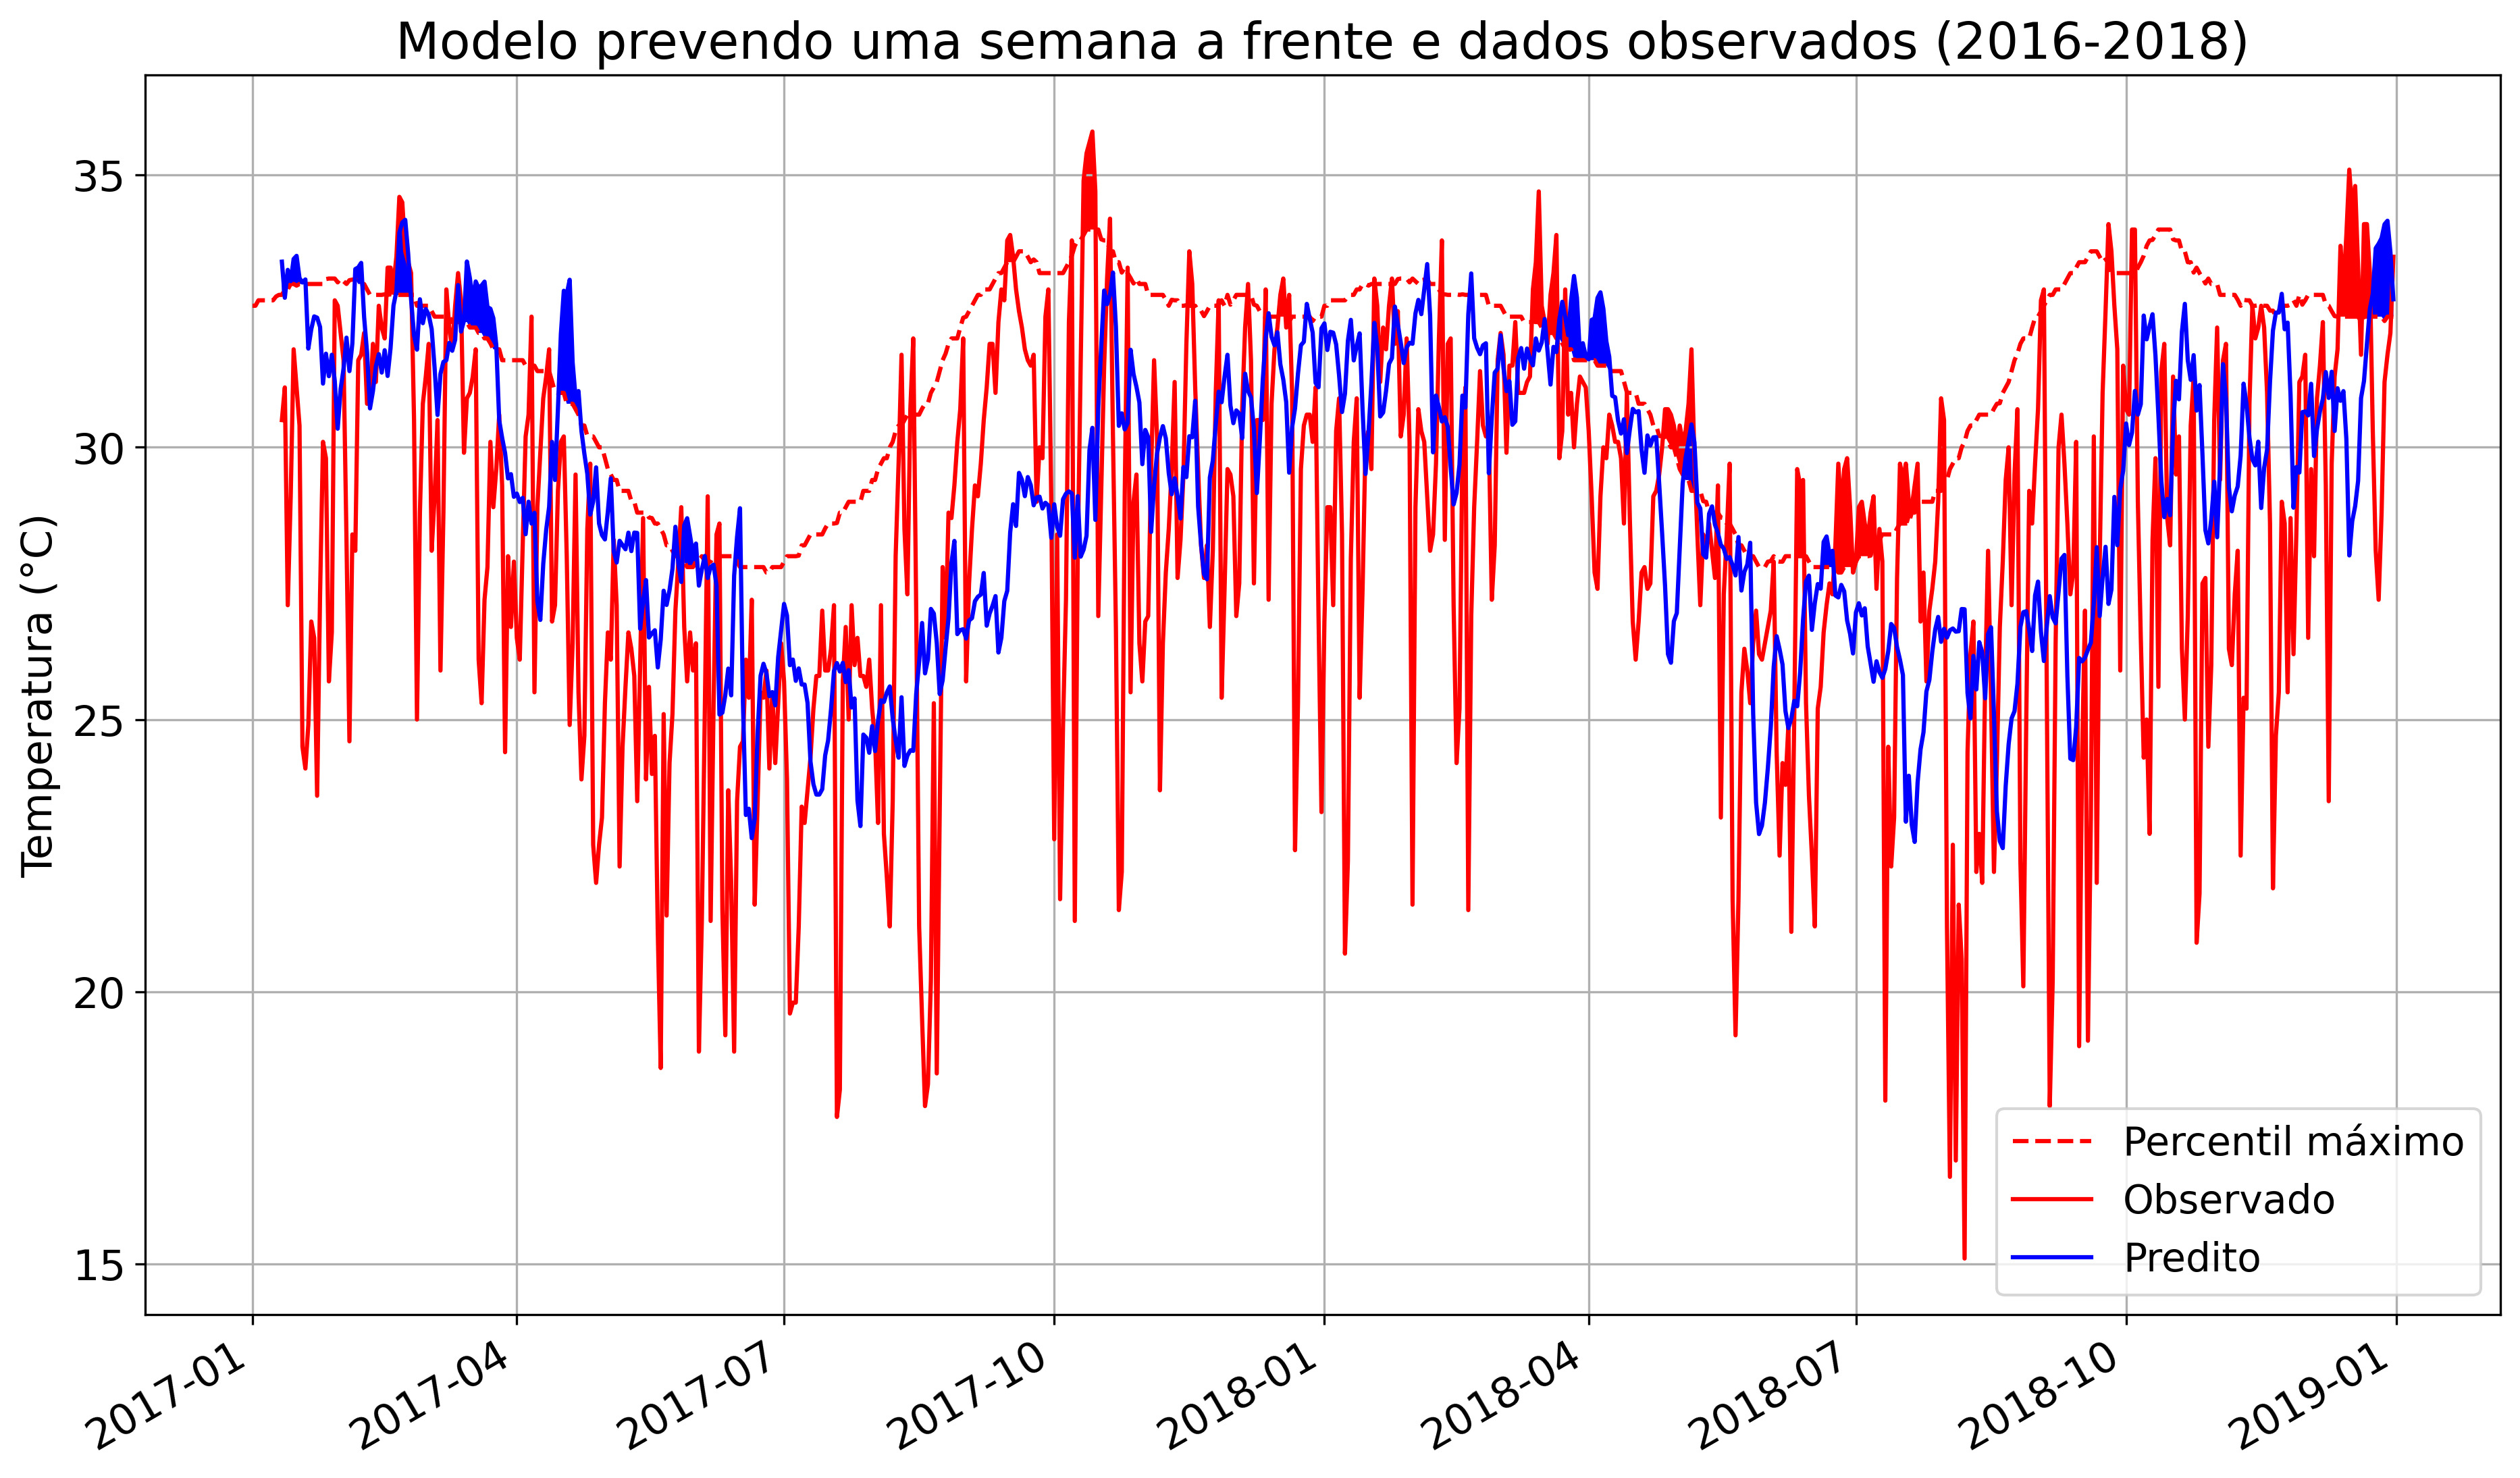

In [ ]:
#N_AIRTMP_MAX
plt.figure(figsize=(15,9),dpi=300)
plt.plot(pred_above['DATE'], pred_above['CMX90pct'],'--r',label='Percentil máximo')
plt.plot(pred_above['DATE'], pred_above['N_AIRTMP_MAX'],'r',label='Observado')
plt.fill_between(pred_above['DATE'], pred_above['CMX90pct'], pred_above['N_AIRTMP_MAX'], where = pred_above['CMX90pct'] <= pred_above['N_AIRTMP_MAX'], facecolor='red', interpolate=True)


#Max_pred
plt.plot(pred_above['DATE'], pred_above['max_pred'],color='b',label='Predito')
plt.fill_between(pred_above['DATE'], pred_above['CMX90pct'], pred_above['max_pred'], where = pred_above['CMX90pct'] <= pred_above['max_pred'], facecolor='b', interpolate=True)

plt.title('Modelo prevendo uma semana a frente e dados observados (2016-2018)',fontsize=18)
plt.ylabel('Temperatura (°C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.autofmt_xdate()
plt.grid()
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [ ]:
rmse_fin_aux = pred_above['max_pred'][10:] - pred_above['N_AIRTMP_MAX'][10:]
rmse_fin_aux = rmse_fin_aux**2
rmse_fin = sum(rmse_fin_aux)/len(rmse_fin_aux)
math.sqrt(rmse_fin)

3.674523120761962

##**Checking HW**

In [ ]:
tex.wave_metrics(pred_above, 'HW', False)


HWN   HWD   HWF
YEAR                 
2017  6.0  12.0  39.0
2018  4.0  18.0  35.0

In [ ]:
tex.wave_metrics(dataset[dataset['YEAR']>=2017], 'HW', False)

HWN  HWD  HWF
YEAR               
2017  2.0  4.0  7.0
2018  1.0  4.0  4.0

In [ ]:
#Where HW REAL
where_hw_real = dataset[dataset['YEAR']>=2017].loc[dataset['HW'] == 1]
where_hw_real

DAY365       DATE    YEAR  ...  above_pct  HW  y
DATE                                   ...                  
2017-03-11      70 2017-03-11  2017.0  ...          1   1  1
2017-03-12      71 2017-03-12  2017.0  ...          1   1  1
2017-03-13      72 2017-03-13  2017.0  ...          1   1  1
2017-10-11     284 2017-10-11  2017.0  ...          1   1  1
2017-10-12     285 2017-10-12  2017.0  ...          1   1  1
2017-10-13     286 2017-10-13  2017.0  ...          1   1  1
2017-10-14     287 2017-10-14  2017.0  ...          1   1  1
2018-12-16     350 2018-12-16  2018.0  ...          1   1  1
2018-12-17     351 2018-12-17  2018.0  ...          1   1  1
2018-12-18     352 2018-12-18  2018.0  ...          1   1  1
2018-12-19     353 2018-12-19  2018.0  ...          1   1  1

[11 rows x 9 columns]

In [ ]:
#Where HW pred
where_hw_pred = pred_above.loc[pred_above['HW'] == 1]
where_hw_pred

DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
24       13 2017-01-13  33.259129  ...   1     32.90     21.00
26       14 2017-01-14  33.052002  ...   1     33.00     21.00
28       15 2017-01-15  33.459301  ...   1     33.00     21.00
30       16 2017-01-16  33.516586  ...   1     32.97     21.00
32       17 2017-01-17  33.107048  ...   1     33.00     21.00
..      ...        ...        ...  ...  ..       ...       ...
721     361 2018-12-27  33.843971  ...   1     32.40     20.70
723     362 2018-12-28  34.096504  ...   1     32.32     20.80
725     363 2018-12-29  34.161163  ...   1     32.40     20.80
727     364 2018-12-30  33.586876  ...   1     32.40     20.80
729     365 2018-12-31  32.717876  ...   1     32.40     20.73

[74 rows x 9 columns]

##**One day ahead (16 years)**

In [ ]:
df_one_day = df_vir[df_vir['YEAR']>=2000]
df_one_day

DAY365       DATE  YEAR  ...  N_AIRTMP_MIN  above_pct  HW
16060       1 2000-01-01  2000  ...          20.0          0   0
16061       2 2000-01-02  2000  ...          19.8          0   0
16062       3 2000-01-03  2000  ...          18.2          0   0
16063       4 2000-01-04  2000  ...          19.2          0   0
16064       5 2000-01-05  2000  ...          20.0          0   0
...       ...        ...   ...  ...           ...        ...  ..
22990     361 2018-12-27  2018  ...          19.0          0   0
22991     362 2018-12-28  2018  ...          18.6          0   0
22992     363 2018-12-29  2018  ...          18.7          0   0
22993     364 2018-12-30  2018  ...          19.8          0   0
22994     365 2018-12-31  2018  ...          19.0          0   0

[6935 rows x 8 columns]

In [ ]:
#Same metrics
dataset_one_day, df_pct = tex.check_HeatWave(df_one_day, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN', df_vir, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN')
dataset_one_day

DAY365       DATE    YEAR  ...  N_AIRTMP_MIN  above_pct  HW
0          1 2000-01-01  2000.0  ...          20.0          0   0
1          2 2000-01-02  2000.0  ...          19.8          0   0
2          3 2000-01-03  2000.0  ...          18.2          0   0
3          4 2000-01-04  2000.0  ...          19.2          0   0
4          5 2000-01-05  2000.0  ...          20.0          0   0
...      ...        ...     ...  ...           ...        ...  ..
6930     361 2018-12-27  2018.0  ...          19.0          0   0
6931     362 2018-12-28  2018.0  ...          18.6          0   0
6932     363 2018-12-29  2018.0  ...          18.7          0   0
6933     364 2018-12-30  2018.0  ...          19.8          0   0
6934     365 2018-12-31  2018.0  ...          19.0          0   0

[6935 rows x 8 columns]

In [ ]:
df_one_day = dataset_one_day
#Transform DATE in datetime format and create MONTH variable
df_one_day['DATE'] = pd.to_datetime(df_one_day['DATE'])


#set datetime index
df_one_day.set_index(df_one_day['DATE'],inplace=True)
df_one_day['y'] = df_one_day['HW']
df_one_day = df_one_day.drop(columns=['HW','DAY365','DATE','YEAR'])
df_one_day.head()

N_RAIN_TOT  N_AIRTMP_MAX  N_AIRTMP_MIN  above_pct  y
DATE                                                            
2000-01-01        71.5          26.8          20.0          0  0
2000-01-02        24.3          25.0          19.8          0  0
2000-01-03        13.7          24.8          18.2          0  0
2000-01-04         6.6          24.8          19.2          0  0
2000-01-05        17.4          24.8          20.0          0  0

In [ ]:
#Fill nan with mean values
df_one_day['N_AIRTMP_MAX'].fillna(df_one_day['N_AIRTMP_MAX'].mean(), inplace=True)

#checking NAN again
print('NAN count:\n')
print(np.sum(df_one_day.isnull()))

NAN count:

N_RAIN_TOT      0
N_AIRTMP_MAX    0
N_AIRTMP_MIN    0
above_pct       0
y               0
dtype: int64


##**Series to supervised (16 years)**

In [ ]:
df.drop(columns=['above_pct','y','N_RAIN_TOT']).head()


N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2000-01-01          26.8          20.0
2000-01-02          25.0          19.8
2000-01-03          24.8          18.2
2000-01-04          24.8          19.2
2000-01-05          24.8          20.0

In [ ]:
#######     train one day ahead (16 years)      ############

n_train_days = 365 * 17 #2000 a 2016

df_train = df.iloc[:n_train_days, :]
df_train = df_train.drop(columns=['above_pct','y','N_RAIN_TOT'])
print(df_train.head(3))
values_train = df_train.values

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(values_train)
print(scaled_train[:5,:])
# specify the number of lag (1 line = 1 day)
n_days = 4
#DAYS_AHEAD = 1
days_ahead = 1
n_features = values_train.shape[1]

reframed_train = series_to_supervised(scaled_train, n_days, days_ahead)
train = reframed_train
print(train.head(5))
train = train.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2000-01-01          26.8          20.0
2000-01-02          25.0          19.8
2000-01-03          24.8          18.2
[[0.56766917 0.78632479]
 [0.5        0.77777778]
 [0.4924812  0.70940171]
 [0.4924812  0.75213675]
 [0.4924812  0.78632479]]
   var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t-1)   var1(t)   var2(t)
4   0.567669   0.786325   0.500000  ...   0.752137  0.492481  0.786325
5   0.500000   0.777778   0.492481  ...   0.786325  0.687970  0.769231
6   0.492481   0.709402   0.492481  ...   0.769231  0.763158  0.760684
7   0.492481   0.752137   0.492481  ...   0.760684  0.725564  0.709402
8   0.492481   0.786325   0.687970  ...   0.709402  0.755639  0.803419

[5 rows x 10 columns]


In [ ]:
#######     test one day ahead (16 years)      ############

df_test = df.iloc[n_train_days:, :]
df_test = df_test.drop(columns=['above_pct',	'y','N_RAIN_TOT'])
print(df_test)
values_test = df_test.values
# ensure all data is float
np.set_printoptions(suppress=True) #supress scientific notation
values_test = values_test.astype('float32')
# normalize features
scaled_test = scaler_train.transform(values_test)
print(scaled_test[:5,:])
print(scaled_test[-5:,:])
# specify the number of lag (days in this case, since each line equals a day)

n_features = values_test.shape[1]
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, n_days, days_ahead)
test = reframed_test
print(test)
test = test.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2017-01-01          31.2          20.4
2017-01-02          31.8          19.9
2017-01-03          31.5          21.5
2017-01-04          34.5          21.0
2017-01-05          29.5          21.0
...                  ...           ...
2018-12-27          28.8          19.0
2018-12-28          31.2          18.6
2018-12-29          31.7          18.7
2018-12-30          32.1          19.8
2018-12-31          33.5          19.0

[730 rows x 2 columns]
[[0.7330828  0.8034188 ]
 [0.7556391  0.78205127]
 [0.7443609  0.8504273 ]
 [0.8571429  0.82905984]
 [0.6691729  0.82905984]]
[[0.6428571  0.74358976]
 [0.7330828  0.72649574]
 [0.7518797  0.7307693 ]
 [0.7669172  0.77777773]
 [0.81954885 0.74358976]]
     var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t-1)   var1(t)   var2(t)
4     0.733083   0.803419   0.755639  ...   0.829060  0.669173  0.829060
5     0.755639   0.782051   0.744361  ...   0.829060  0.721804  0.80769

In [ ]:

n_obs = n_days * n_features

#Train and test
#ACRESCENTEI O TRAIN_Y e TEST_Y CORRETAMENTE (THIAGO)
#preve temperatura máxima
train_X, train_y = train[:, :n_obs], train[:, -2]
test_X, test_y = test[:, :n_obs], test[:, -2]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input (train_X and test_X) to be 3D [SAMPLES, TIMESTEPS, FEATURES]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6201, 8) 6201 (6201,)
(6201, 4, 2) (6201,) (726, 4, 2) (726,)


Epoch 1/170
42/42 - 3s - loss: 0.1181 - val_loss: 0.0135
Epoch 2/170
42/42 - 0s - loss: 0.0145 - val_loss: 0.0133
Epoch 3/170
42/42 - 0s - loss: 0.0143 - val_loss: 0.0131
Epoch 4/170
42/42 - 0s - loss: 0.0142 - val_loss: 0.0130
Epoch 5/170
42/42 - 0s - loss: 0.0140 - val_loss: 0.0129
Epoch 6/170
42/42 - 0s - loss: 0.0138 - val_loss: 0.0128
Epoch 7/170
42/42 - 0s - loss: 0.0136 - val_loss: 0.0126
Epoch 8/170
42/42 - 0s - loss: 0.0134 - val_loss: 0.0125
Epoch 9/170
42/42 - 0s - loss: 0.0133 - val_loss: 0.0124
Epoch 10/170
42/42 - 0s - loss: 0.0131 - val_loss: 0.0123
Epoch 11/170
42/42 - 0s - loss: 0.0129 - val_loss: 0.0121
Epoch 12/170
42/42 - 0s - loss: 0.0128 - val_loss: 0.0120
Epoch 13/170
42/42 - 0s - loss: 0.0126 - val_loss: 0.0119
Epoch 14/170
42/42 - 0s - loss: 0.0124 - val_loss: 0.0117
Epoch 15/170
42/42 - 0s - loss: 0.0122 - val_loss: 0.0116
Epoch 16/170
42/42 - 0s - loss: 0.0121 - val_loss: 0.0115
Epoch 17/170
42/42 - 0s - loss: 0.0119 - val_loss: 0.0113
Epoch 18/170
42/42 - 0s

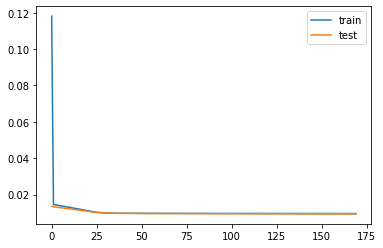

In [ ]:
#ORIGINAL

# design network
model = Sequential()
model.add(LSTM(70,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='nadam')

# fit network
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', patience=170,verbose=0)
callbacks_list = [stop]

history = model.fit(train_X, train_y, epochs=170, batch_size=150, callbacks = callbacks_list, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat1 = model.predict(test_X)
#Reshape test_X to get 7 random columns
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

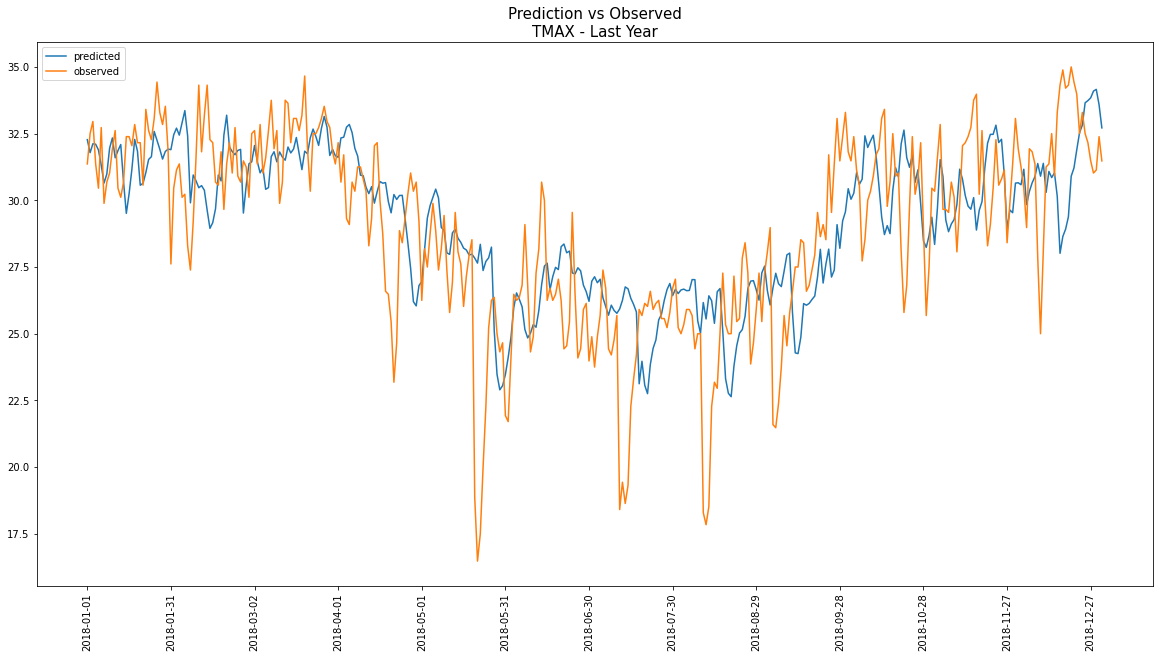

In [ ]:

inv_param = -1*(n_features-1)
# invert scaling for forecast
inv_yhat1 = concatenate((yhat1, test_X[:, inv_param:]), axis=1)
inv_yhat1 = scaler_train.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
'''
Q: why do we use -7 in 'test_X[:, -7:]' especially?
A: We are only interested in inverting the target, but the transform requires 
the same columns when inverting as when transforming. Therefore we are adding 
the target with other input vars for the inverse operation.

Isto é, quando fizemos o scaling na variavel 'values' tinhamos 8 colunas, assim,
concatenamos o 'yhat1' (1 coluna) com test_X (7 colunas). (Apenas para fornecer
o shape adequado para inversão. Estamos interessados em inverter apenas 'yhat1').
'''
# invert scaling for actual
'''
Essa etapa de inversão de test_y não seria necessária se escalarmos apenas
os y de treino, uma vez que o algoritmo não precisa conhecer o y de teste
'''
#FICAR ATENTO NESSA PARTE DE "DESESCALAR"
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, inv_param:]), axis=1)
inv_y = scaler_train.inverse_transform(inv_y)
inv_y = inv_y[:,0]
'''
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat1))
print(model.summary(),'\n')
print('n atrasos = ',n_days,'dias')
print('Test RMSE: %.3f' % rmse)
'''
# plot time series
ts_size = 365 #how many days from the end do you wanna see?
interval = 30 #days invterval for x ticks

plt.figure(figsize=[20,10])
plt.plot(inv_yhat1[-ts_size:], label='predicted')
plt.plot(inv_y[-ts_size:], label='observed')
plt.title('Prediction vs Observed\nTMAX - Last Year',fontsize=15)
dates = df.index[-ts_size:-1].date
ticks = []
for i in list(range(0,len(dates),interval)):
  ticks.append(dates[i])
plt.xticks(range(0, ts_size,interval),ticks,rotation=90)
plt.legend()
plt.show()

In [ ]:
rmse_16_years = np.sqrt(mean_squared_error(inv_y, inv_yhat1))
print(model.summary(),'\n')
print('n atrasos = ',n_days,'dias')
print('Test RMSE: %.3f' % rmse_16_years)

rmse_week_aux = pred_above['max_pred'][10:] - pred_above['N_AIRTMP_MAX'][10:]
rmse_week_aux = rmse_week_aux**2
rmse_week = sum(rmse_week_aux)/len(rmse_week_aux)
print(math.sqrt(rmse_week))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70)                20440     
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 20,511
Trainable params: 20,511
Non-trainable params: 0
_________________________________________________________________
None 

n atrasos =  4 dias
Test RMSE: 2.493
3.674523120761962


NameError: ignored

##**Results LSTM (16 years) one day ahead**

In [ ]:
#Create a new data frane for max_pred
temp_pred_16_years = pd.DataFrame()
temp_pred_16_years['max_pred'] = inv_yhat1
temp_pred_16_years
temp_pred_16_years['DATE'] = df.index[n_train_days + n_days + days_ahead -1 :]
df_merge_col_16_years = pd.merge(temp_pred_16_years, df, on='DATE')
df_merge_col_16_years = df_merge_col_16_years.drop(columns=['above_pct', 'y'])


#Climatex for temp_pred
#Using the same normal climatic and real temp min to check max_temp_pred performance
pred_above_16_years, df_pct_16_years = tex.check_HeatWave(df_merge_col_16_years, 'max_pred', 'N_AIRTMP_MAX', df_vir, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN')
pred_above_16_years = pred_above_16_years.drop(columns=['N_RAIN_TOT'])
pred_above_16_years = pd.merge(pred_above_16_years, df_pct, on='DAY365')
pred_above_16_years = pred_above_16_years.sort_values(by='DATE')
pred_above_16_years.head(15)

DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
0        1 2017-01-01        NaN  ...   0     32.60      20.8
2        2 2017-01-02        NaN  ...   0     32.60      20.8
4        3 2017-01-03        NaN  ...   0     32.70      20.8
6        4 2017-01-04        NaN  ...   0     32.70      20.8
8        5 2017-01-05  33.273232  ...   0     32.70      20.8
10       6 2017-01-06  29.531639  ...   0     32.70      20.8
12       7 2017-01-07  31.143032  ...   0     32.70      21.0
14       8 2017-01-08  31.867186  ...   0     32.70      21.0
16       9 2017-01-09  31.698011  ...   0     32.77      21.0
18      10 2017-01-10  32.394516  ...   0     32.80      21.0
20      11 2017-01-11  31.368235  ...   0     32.80      21.0
22      12 2017-01-12  30.754547  ...   0     32.90      21.0
24      13 2017-01-13  31.350216  ...   0     32.90      21.0
26      14 2017-01-14  27.854460  ...   0     33.00      21.0
28      15 2017-01-15  29.856022  ...   0     33.00      21.0

[15 rows x 9 columns]

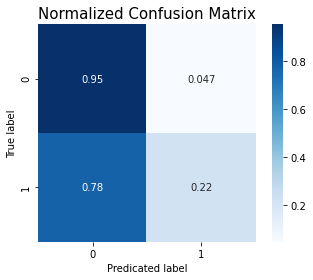

In [ ]:
cm_16_years = confusion_matrix(df_vir[df_vir['YEAR']>=2017]['above_pct'], pred_above_16_years['above_pct'],normalize='true')
sns.heatmap(cm_16_years, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 15)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

In [ ]:
metrics_16_years = tex.wave_metrics(pred_above_16_years, 'HW', False)
metrics_16_years

HWN  HWD   HWF
YEAR                
2017  0.0  0.0   0.0
2018  7.0  6.0  26.0

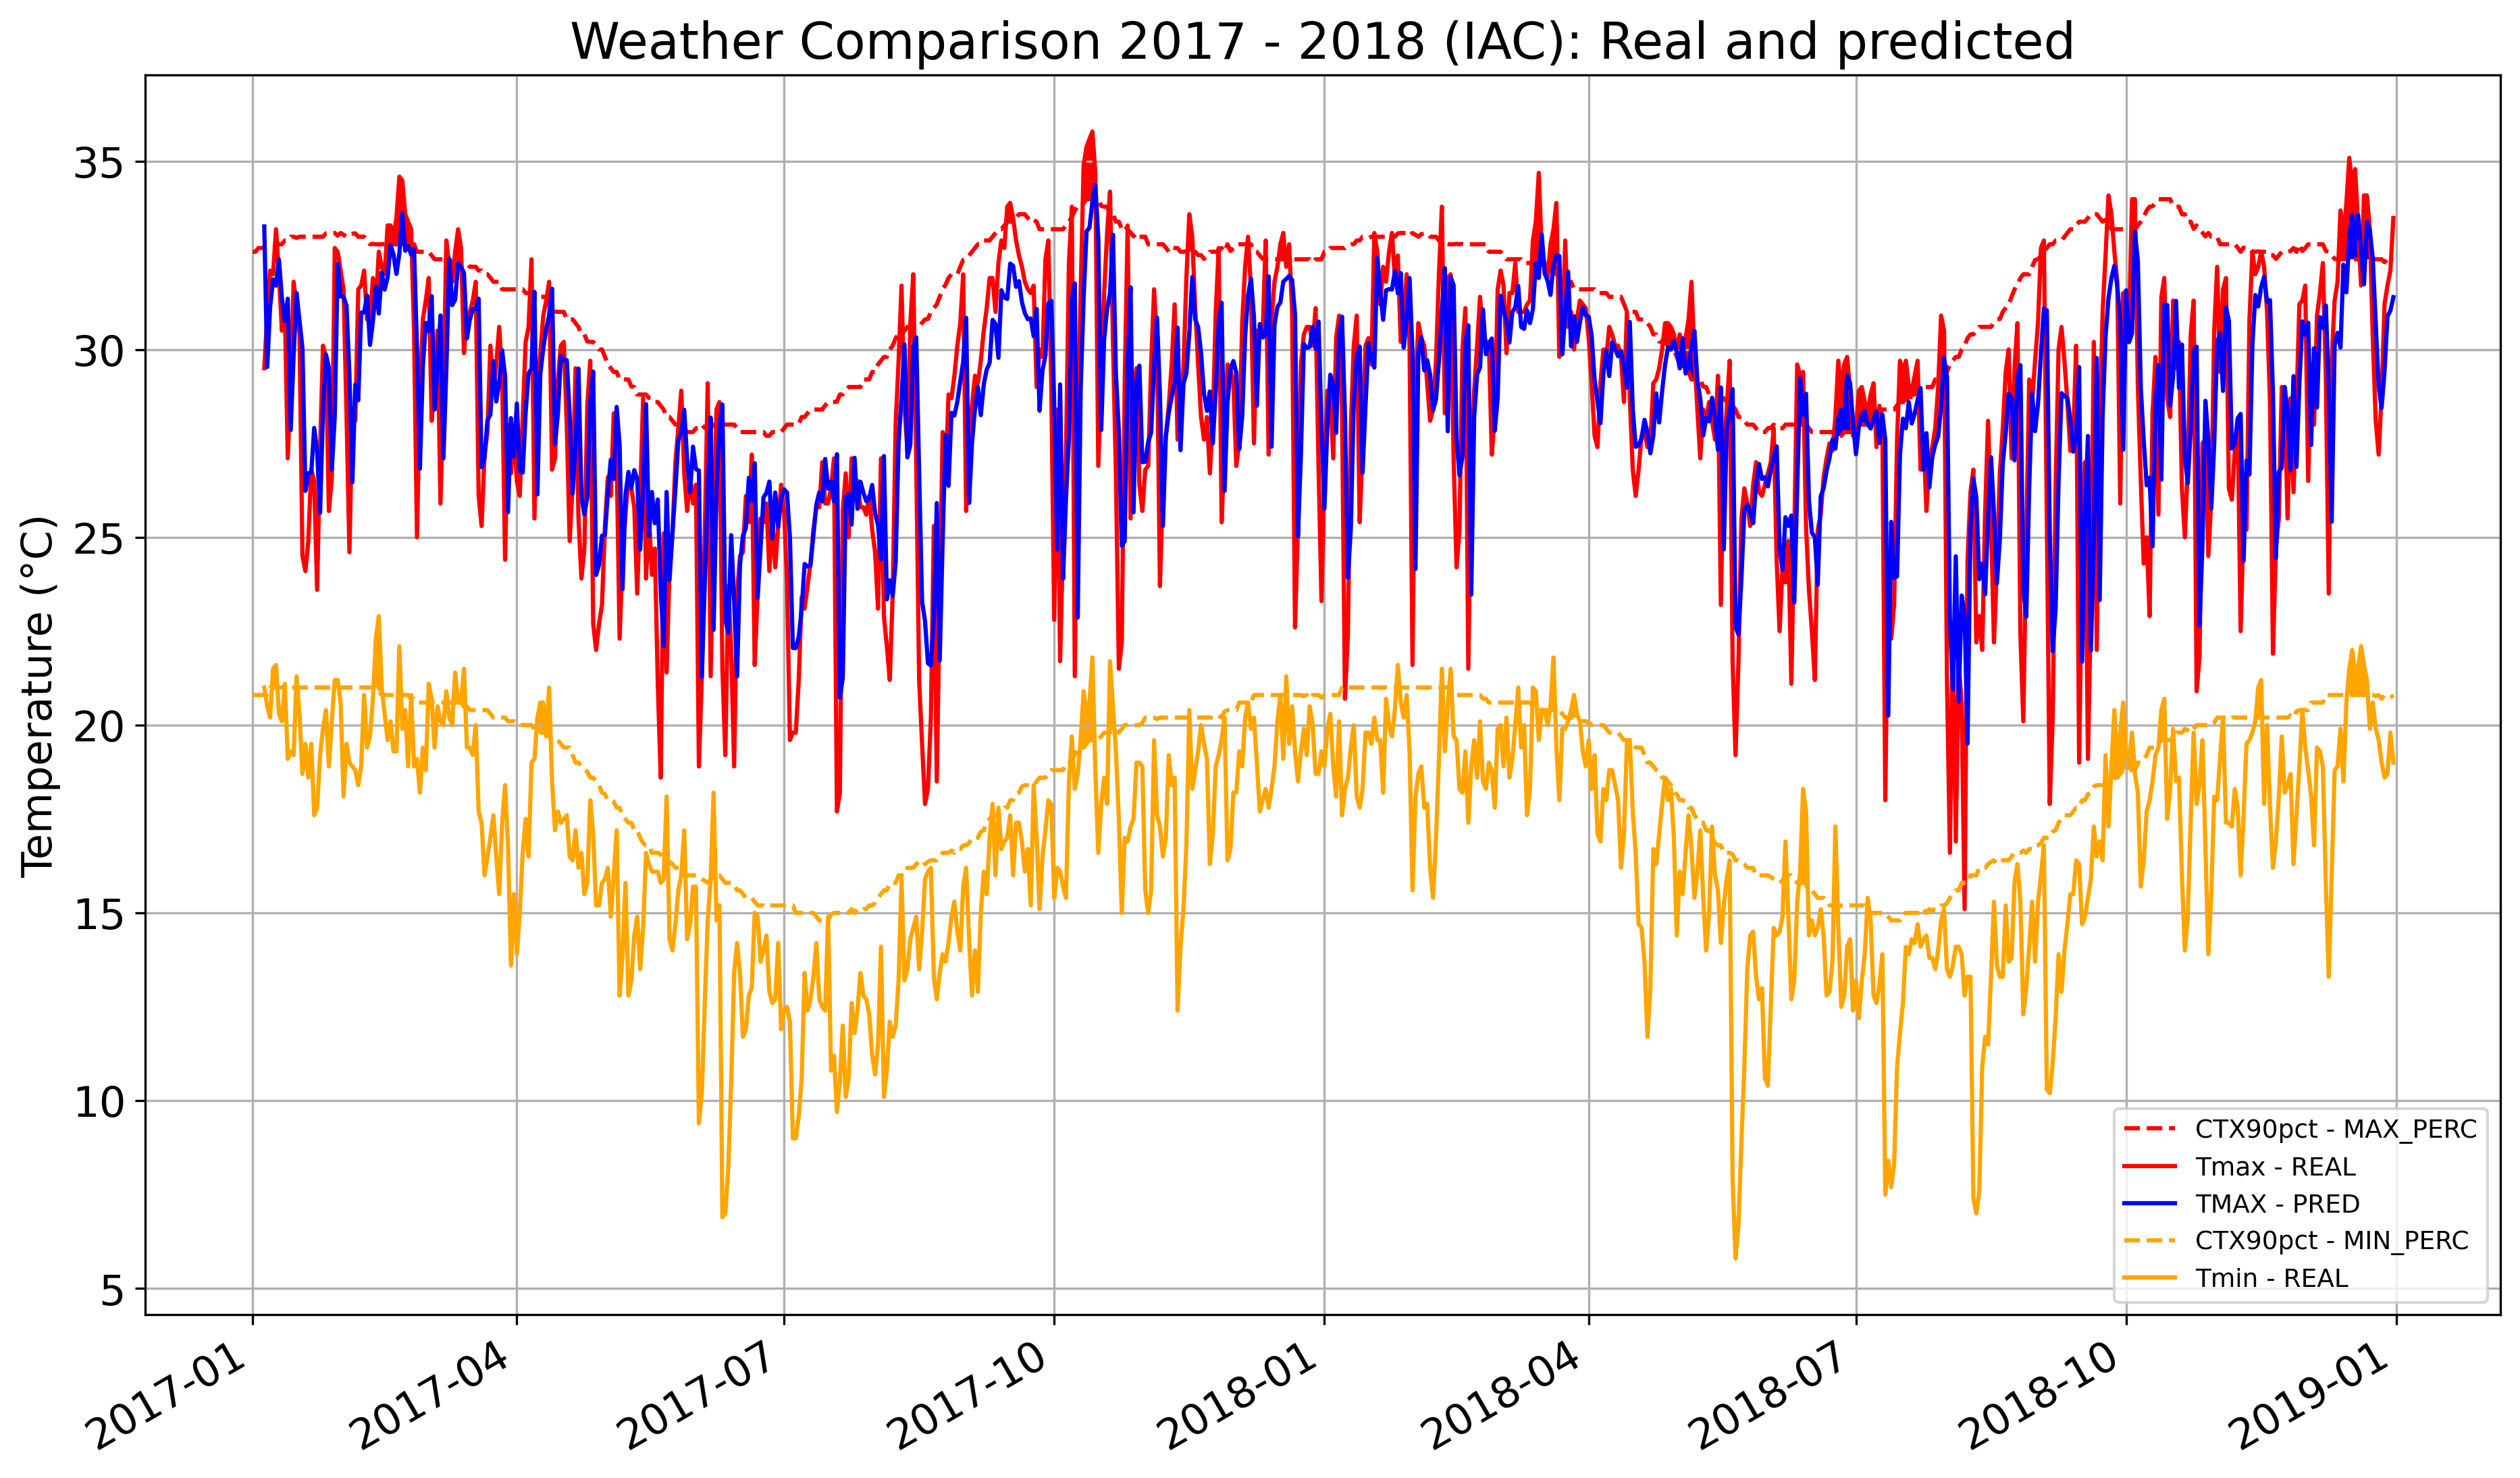

In [ ]:
#CTX90pct N_AIRTMP_MAX_real
plt.figure(figsize=(15,9),dpi=300)
plt.plot(pred_above_16_years['DATE'], pred_above_16_years['CMX90pct'],'--r',label='CTX90pct - MAX_PERC')
plt.plot(pred_above_16_years['DATE'], pred_above_16_years['N_AIRTMP_MAX'],'r',label='Tmax - REAL')
plt.fill_between(pred_above_16_years['DATE'], pred_above_16_years['CMX90pct'], pred_above_16_years['N_AIRTMP_MAX'], where = pred_above_16_years['CMX90pct'] <= pred_above_16_years['N_AIRTMP_MAX'], facecolor='red', interpolate=True)

#CTN90pct N_AIRTMP_MAX_pred
plt.plot(pred_above_16_years['DATE'], pred_above_16_years['max_pred'],'b',label='TMAX - PRED')
plt.fill_between(pred_above_16_years['DATE'], pred_above_16_years['CMX90pct'], pred_above_16_years['max_pred'], where = pred_above_16_years['CMX90pct'] <= pred_above_16_years['max_pred'], facecolor='blue', interpolate=True)


#CTX90pct N_AIRTMP_MIN_REAL
plt.plot(pred_above_16_years['DATE'], pred_above_16_years['CMN90pct'],'--',color='orange',label='CTX90pct - MIN_PERC')
plt.plot(pred_above_16_years['DATE'], pred_above_16_years['N_AIRTMP_MIN'],color='orange',label='Tmin - REAL')
plt.fill_between(pred_above_16_years['DATE'], pred_above_16_years['CMN90pct'], pred_above_16_years['N_AIRTMP_MIN'], where = pred_above['CMN90pct'] <= pred_above_16_years['N_AIRTMP_MIN'], facecolor='orange', interpolate=True)


#CTN90pct N_AIRTMP_MIN_PRED
#plt.plot(df_merge_col['DATE'], df_merge_col['min_pred'],color='gray',label='Tmin - PRED')
#plt.fill_between(df_merge_col['DATE'], df_merge_col['CMN90pct_x'], df_merge_col['min_pred'], where = df_merge_col['CMN90pct_x'] <= df_merge_col['min_pred'], facecolor='gray', interpolate=True)


plt.title('Weather Comparison 2017 - 2018 (IAC): Real and predicted',fontsize=18)
plt.ylabel('Temperature (°C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.autofmt_xdate()
plt.grid()
plt.legend(loc=4, prop={'size': 9})
plt.show()

##**LSTM one day ahead (8 Years)**

In [ ]:
df_one_day

N_RAIN_TOT  N_AIRTMP_MAX  N_AIRTMP_MIN  above_pct  y
DATE                                                            
2000-01-01        71.5          26.8          20.0          0  0
2000-01-02        24.3          25.0          19.8          0  0
2000-01-03        13.7          24.8          18.2          0  0
2000-01-04         6.6          24.8          19.2          0  0
2000-01-05        17.4          24.8          20.0          0  0
...                ...           ...           ...        ... ..
2018-12-27         0.0          28.8          19.0          0  0
2018-12-28        23.1          31.2          18.6          0  0
2018-12-29         0.0          31.7          18.7          0  0
2018-12-30         0.0          32.1          19.8          0  0
2018-12-31         0.0          33.5          19.0          0  0

[6935 rows x 5 columns]

In [ ]:
df_one_day = df_one_day.iloc[365*9:]
df_one_day

N_RAIN_TOT  N_AIRTMP_MAX  N_AIRTMP_MIN  above_pct  y
DATE                                                            
2009-01-01         6.0          31.6          19.8          0  0
2009-01-02        16.2          28.3          19.7          0  0
2009-01-03         6.3          26.1          19.7          0  0
2009-01-04         9.9          26.4          17.3          0  0
2009-01-05         0.2          21.8          16.0          0  0
...                ...           ...           ...        ... ..
2018-12-27         0.0          28.8          19.0          0  0
2018-12-28        23.1          31.2          18.6          0  0
2018-12-29         0.0          31.7          18.7          0  0
2018-12-30         0.0          32.1          19.8          0  0
2018-12-31         0.0          33.5          19.0          0  0

[3650 rows x 5 columns]

##**Series to supervised (8 years)**

In [ ]:
#######     train one day ahead (8 years)      ############

n_train_days = 365 * 8 #2009 a 2016

df_train = df_one_day.iloc[:n_train_days, :]
df_train = df_train.drop(columns=['above_pct','y','N_RAIN_TOT'])
print(df_train.head(3))
values_train = df_train.values

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(values_train)
print(scaled_train[:5,:])
# specify the number of lag (1 line = 1 day)
n_days = 4
#DAYS_AHEAD = 1
days_ahead = 1
n_features = values_train.shape[1]

reframed_train = series_to_supervised(scaled_train, n_days, days_ahead)
train = reframed_train
print(train.head(5))
train = train.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2009-01-01          31.6          19.8
2009-01-02          28.3          19.7
2009-01-03          26.1          19.7
[[0.7481203  0.75700935]
 [0.62406015 0.75233645]
 [0.54135338 0.75233645]
 [0.55263158 0.64018692]
 [0.37969925 0.57943925]]
   var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t-1)   var1(t)   var2(t)
4   0.748120   0.757009   0.624060  ...   0.640187  0.379699  0.579439
5   0.624060   0.752336   0.541353  ...   0.579439  0.500000  0.602804
6   0.541353   0.752336   0.552632  ...   0.602804  0.624060  0.677570
7   0.552632   0.640187   0.379699  ...   0.677570  0.680451  0.672897
8   0.379699   0.579439   0.500000  ...   0.672897  0.759398  0.714953

[5 rows x 10 columns]


In [ ]:
#######     test one day ahead (8 years)      ############

df_test = df_one_day.iloc[n_train_days:, :]
df_test = df_test.drop(columns=['above_pct',	'y','N_RAIN_TOT'])
print(df_test)
values_test = df_test.values
# ensure all data is float
np.set_printoptions(suppress=True) #supress scientific notation
values_test = values_test.astype('float32')
# normalize features
scaled_test = scaler_train.transform(values_test)
print(scaled_test[:5,:])
print(scaled_test[-5:,:])
# specify the number of lag (days in this case, since each line equals a day)

n_features = values_test.shape[1]
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, n_days, days_ahead)
test = reframed_test
print(test)
test = test.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2017-01-01          31.2          20.4
2017-01-02          31.8          19.9
2017-01-03          31.5          21.5
2017-01-04          34.5          21.0
2017-01-05          29.5          21.0
...                  ...           ...
2018-12-27          28.8          19.0
2018-12-28          31.2          18.6
2018-12-29          31.7          18.7
2018-12-30          32.1          19.8
2018-12-31          33.5          19.0

[730 rows x 2 columns]
[[0.7330828  0.78504676]
 [0.7556391  0.7616823 ]
 [0.7443609  0.8364486 ]
 [0.8571429  0.8130841 ]
 [0.6691729  0.8130841 ]]
[[0.6428571  0.7196262 ]
 [0.7330828  0.70093465]
 [0.7518797  0.70560753]
 [0.7669172  0.7570093 ]
 [0.81954885 0.7196262 ]]
     var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t-1)   var1(t)   var2(t)
4     0.733083   0.785047   0.755639  ...   0.813084  0.669173  0.813084
5     0.755639   0.761682   0.744361  ...   0.813084  0.721804  0.78972

In [ ]:
n_obs = n_days * n_features

#Train and test
#ACRESCENTEI O TRAIN_Y e TEST_Y CORRETAMENTE (THIAGO)
#preve temperatura máxima
train_X, train_y = train[:, :n_obs], train[:, -2]
test_X, test_y = test[:, :n_obs], test[:, -2]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input (train_X and test_X) to be 3D [SAMPLES, TIMESTEPS, FEATURES]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2916, 8) 2916 (2916,)
(2916, 4, 2) (2916,) (726, 4, 2) (726,)


Epoch 1/170
20/20 - 3s - loss: 0.1202 - val_loss: 0.0139
Epoch 2/170
20/20 - 0s - loss: 0.0155 - val_loss: 0.0131
Epoch 3/170
20/20 - 0s - loss: 0.0150 - val_loss: 0.0129
Epoch 4/170
20/20 - 0s - loss: 0.0148 - val_loss: 0.0128
Epoch 5/170
20/20 - 0s - loss: 0.0146 - val_loss: 0.0127
Epoch 6/170
20/20 - 0s - loss: 0.0145 - val_loss: 0.0126
Epoch 7/170
20/20 - 0s - loss: 0.0143 - val_loss: 0.0125
Epoch 8/170
20/20 - 0s - loss: 0.0142 - val_loss: 0.0124
Epoch 9/170
20/20 - 0s - loss: 0.0141 - val_loss: 0.0123
Epoch 10/170
20/20 - 0s - loss: 0.0139 - val_loss: 0.0123
Epoch 11/170
20/20 - 0s - loss: 0.0138 - val_loss: 0.0122
Epoch 12/170
20/20 - 0s - loss: 0.0137 - val_loss: 0.0121
Epoch 13/170
20/20 - 0s - loss: 0.0136 - val_loss: 0.0120
Epoch 14/170
20/20 - 0s - loss: 0.0135 - val_loss: 0.0120
Epoch 15/170
20/20 - 0s - loss: 0.0134 - val_loss: 0.0119
Epoch 16/170
20/20 - 0s - loss: 0.0133 - val_loss: 0.0118
Epoch 17/170
20/20 - 0s - loss: 0.0133 - val_loss: 0.0118
Epoch 18/170
20/20 - 0s

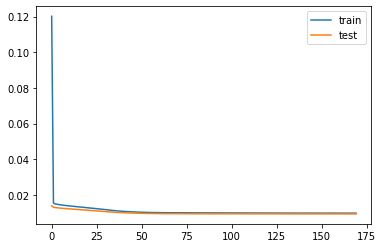

In [ ]:
#ORIGINAL

# design network
model = Sequential()
model.add(LSTM(70,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='nadam')

# fit network
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', patience=170,verbose=0)
callbacks_list = [stop]

history = model.fit(train_X, train_y, epochs=170, batch_size=150, callbacks = callbacks_list, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat1 = model.predict(test_X)
#Reshape test_X to get 7 random columns
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

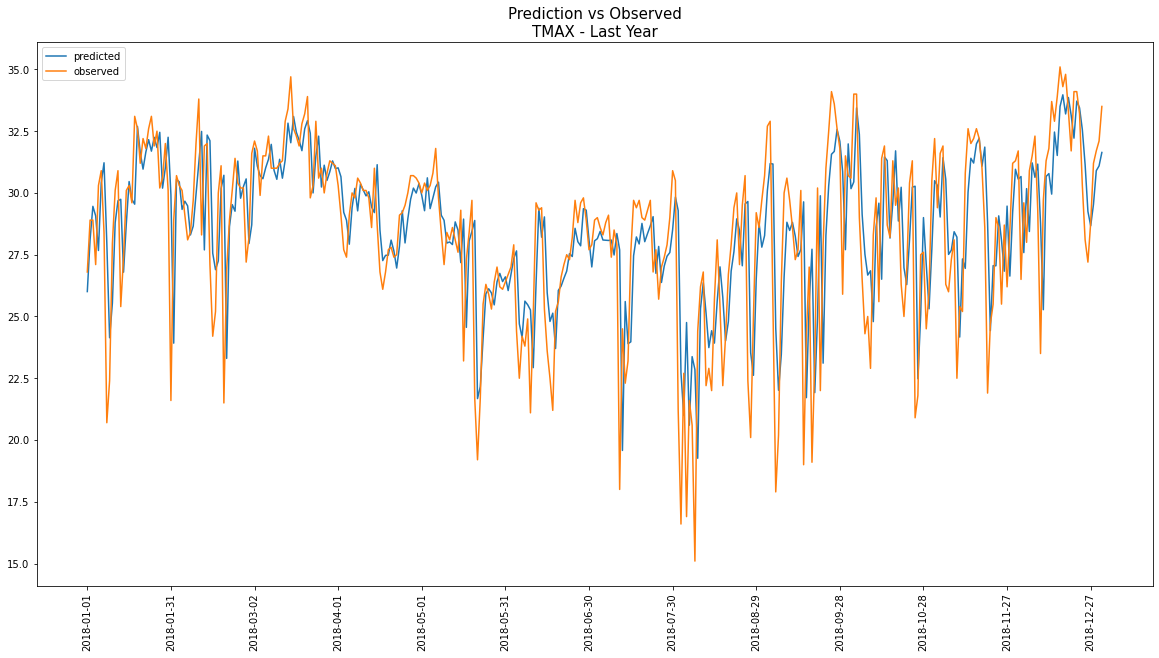

In [ ]:
inv_param = -1*(n_features-1)
# invert scaling for forecast
inv_yhat1 = concatenate((yhat1, test_X[:, inv_param:]), axis=1)
inv_yhat1 = scaler_train.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]



test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, inv_param:]), axis=1)
inv_y = scaler_train.inverse_transform(inv_y)
inv_y = inv_y[:,0]


# plot time series
ts_size = 365 #how many days from the end do you wanna see?
interval = 30 #days invterval for x ticks

plt.figure(figsize=[20,10])
plt.plot(inv_yhat1[-ts_size:], label='predicted')
plt.plot(inv_y[-ts_size:], label='observed')
plt.title('Prediction vs Observed\nTMAX - Last Year',fontsize=15)
dates = df.index[-ts_size:-1].date
ticks = []
for i in list(range(0,len(dates),interval)):
  ticks.append(dates[i])
plt.xticks(range(0, ts_size,interval),ticks,rotation=90)
plt.legend()
plt.show()

In [ ]:
rmse_8_years = np.sqrt(mean_squared_error(inv_y, inv_yhat1))
print(model.summary(),'\n')
print('n atrasos = ',n_days,'dias')
print('Test RMSE: %.3f' % rmse_8_years)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 70)                20440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 71        
Total params: 20,511
Trainable params: 20,511
Non-trainable params: 0
_________________________________________________________________
None 

n atrasos =  4 dias
Test RMSE: 2.575


##**Results LSTM 8 years one day ahead**

In [ ]:
#Create a new data frane for max_pred
temp_pred_8_years = pd.DataFrame()
temp_pred_8_years['max_pred'] = inv_yhat1
temp_pred_8_years
temp_pred_8_years['DATE'] = df_one_day.index[n_train_days + n_days :]
df_merge_col_8_years = pd.merge(temp_pred_8_years, df, on='DATE')
df_merge_col_8_years = df_merge_col_8_years.drop(columns=['above_pct', 'y'])


#Climatex for temp_pred
#Using the same normal climatic and real temp min to check max_temp_pred performance
pred_above_8_years, df_pct_8_years = tex.check_HeatWave(df_merge_col_8_years, 'max_pred', 'N_AIRTMP_MAX', df_vir, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN')
pred_above_8_years = pred_above_8_years.drop(columns=['N_RAIN_TOT'])
pred_above_8_years = pd.merge(pred_above_8_years, df_pct_8_years, on='DAY365')
pred_above_8_years = pred_above_8_years.sort_values(by='DATE')
pred_above_8_years.head(15)


DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
0        1 2017-01-01        NaN  ...   0     32.60      20.8
2        2 2017-01-02        NaN  ...   0     32.60      20.8
4        3 2017-01-03        NaN  ...   0     32.70      20.8
6        4 2017-01-04        NaN  ...   0     32.70      20.8
8        5 2017-01-05  33.425858  ...   0     32.70      20.8
10       6 2017-01-06  29.812656  ...   0     32.70      20.8
12       7 2017-01-07  31.373457  ...   0     32.70      21.0
14       8 2017-01-08  32.137886  ...   0     32.70      21.0
16       9 2017-01-09  32.052860  ...   0     32.77      21.0
18      10 2017-01-10  32.632145  ...   0     32.80      21.0
20      11 2017-01-11  31.470310  ...   0     32.80      21.0
22      12 2017-01-12  31.027020  ...   0     32.90      21.0
24      13 2017-01-13  31.791212  ...   0     32.90      21.0
26      14 2017-01-14  27.850990  ...   0     33.00      21.0
28      15 2017-01-15  30.088175  ...   0     33.00      21.0

[15 rows x 9 columns]

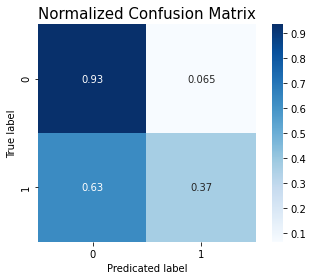

In [ ]:
cm_8_years = confusion_matrix(df_vir[df_vir['YEAR']>=2017]['above_pct'], pred_above_8_years['above_pct'],normalize='true')
sns.heatmap(cm_8_years, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 15)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

In [ ]:
metrics_8_years = tex.wave_metrics(pred_above_8_years, 'HW', False)
metrics_8_years

HWN  HWD   HWF
YEAR                
2017  0.0  0.0   0.0
2018  7.0  6.0  28.0

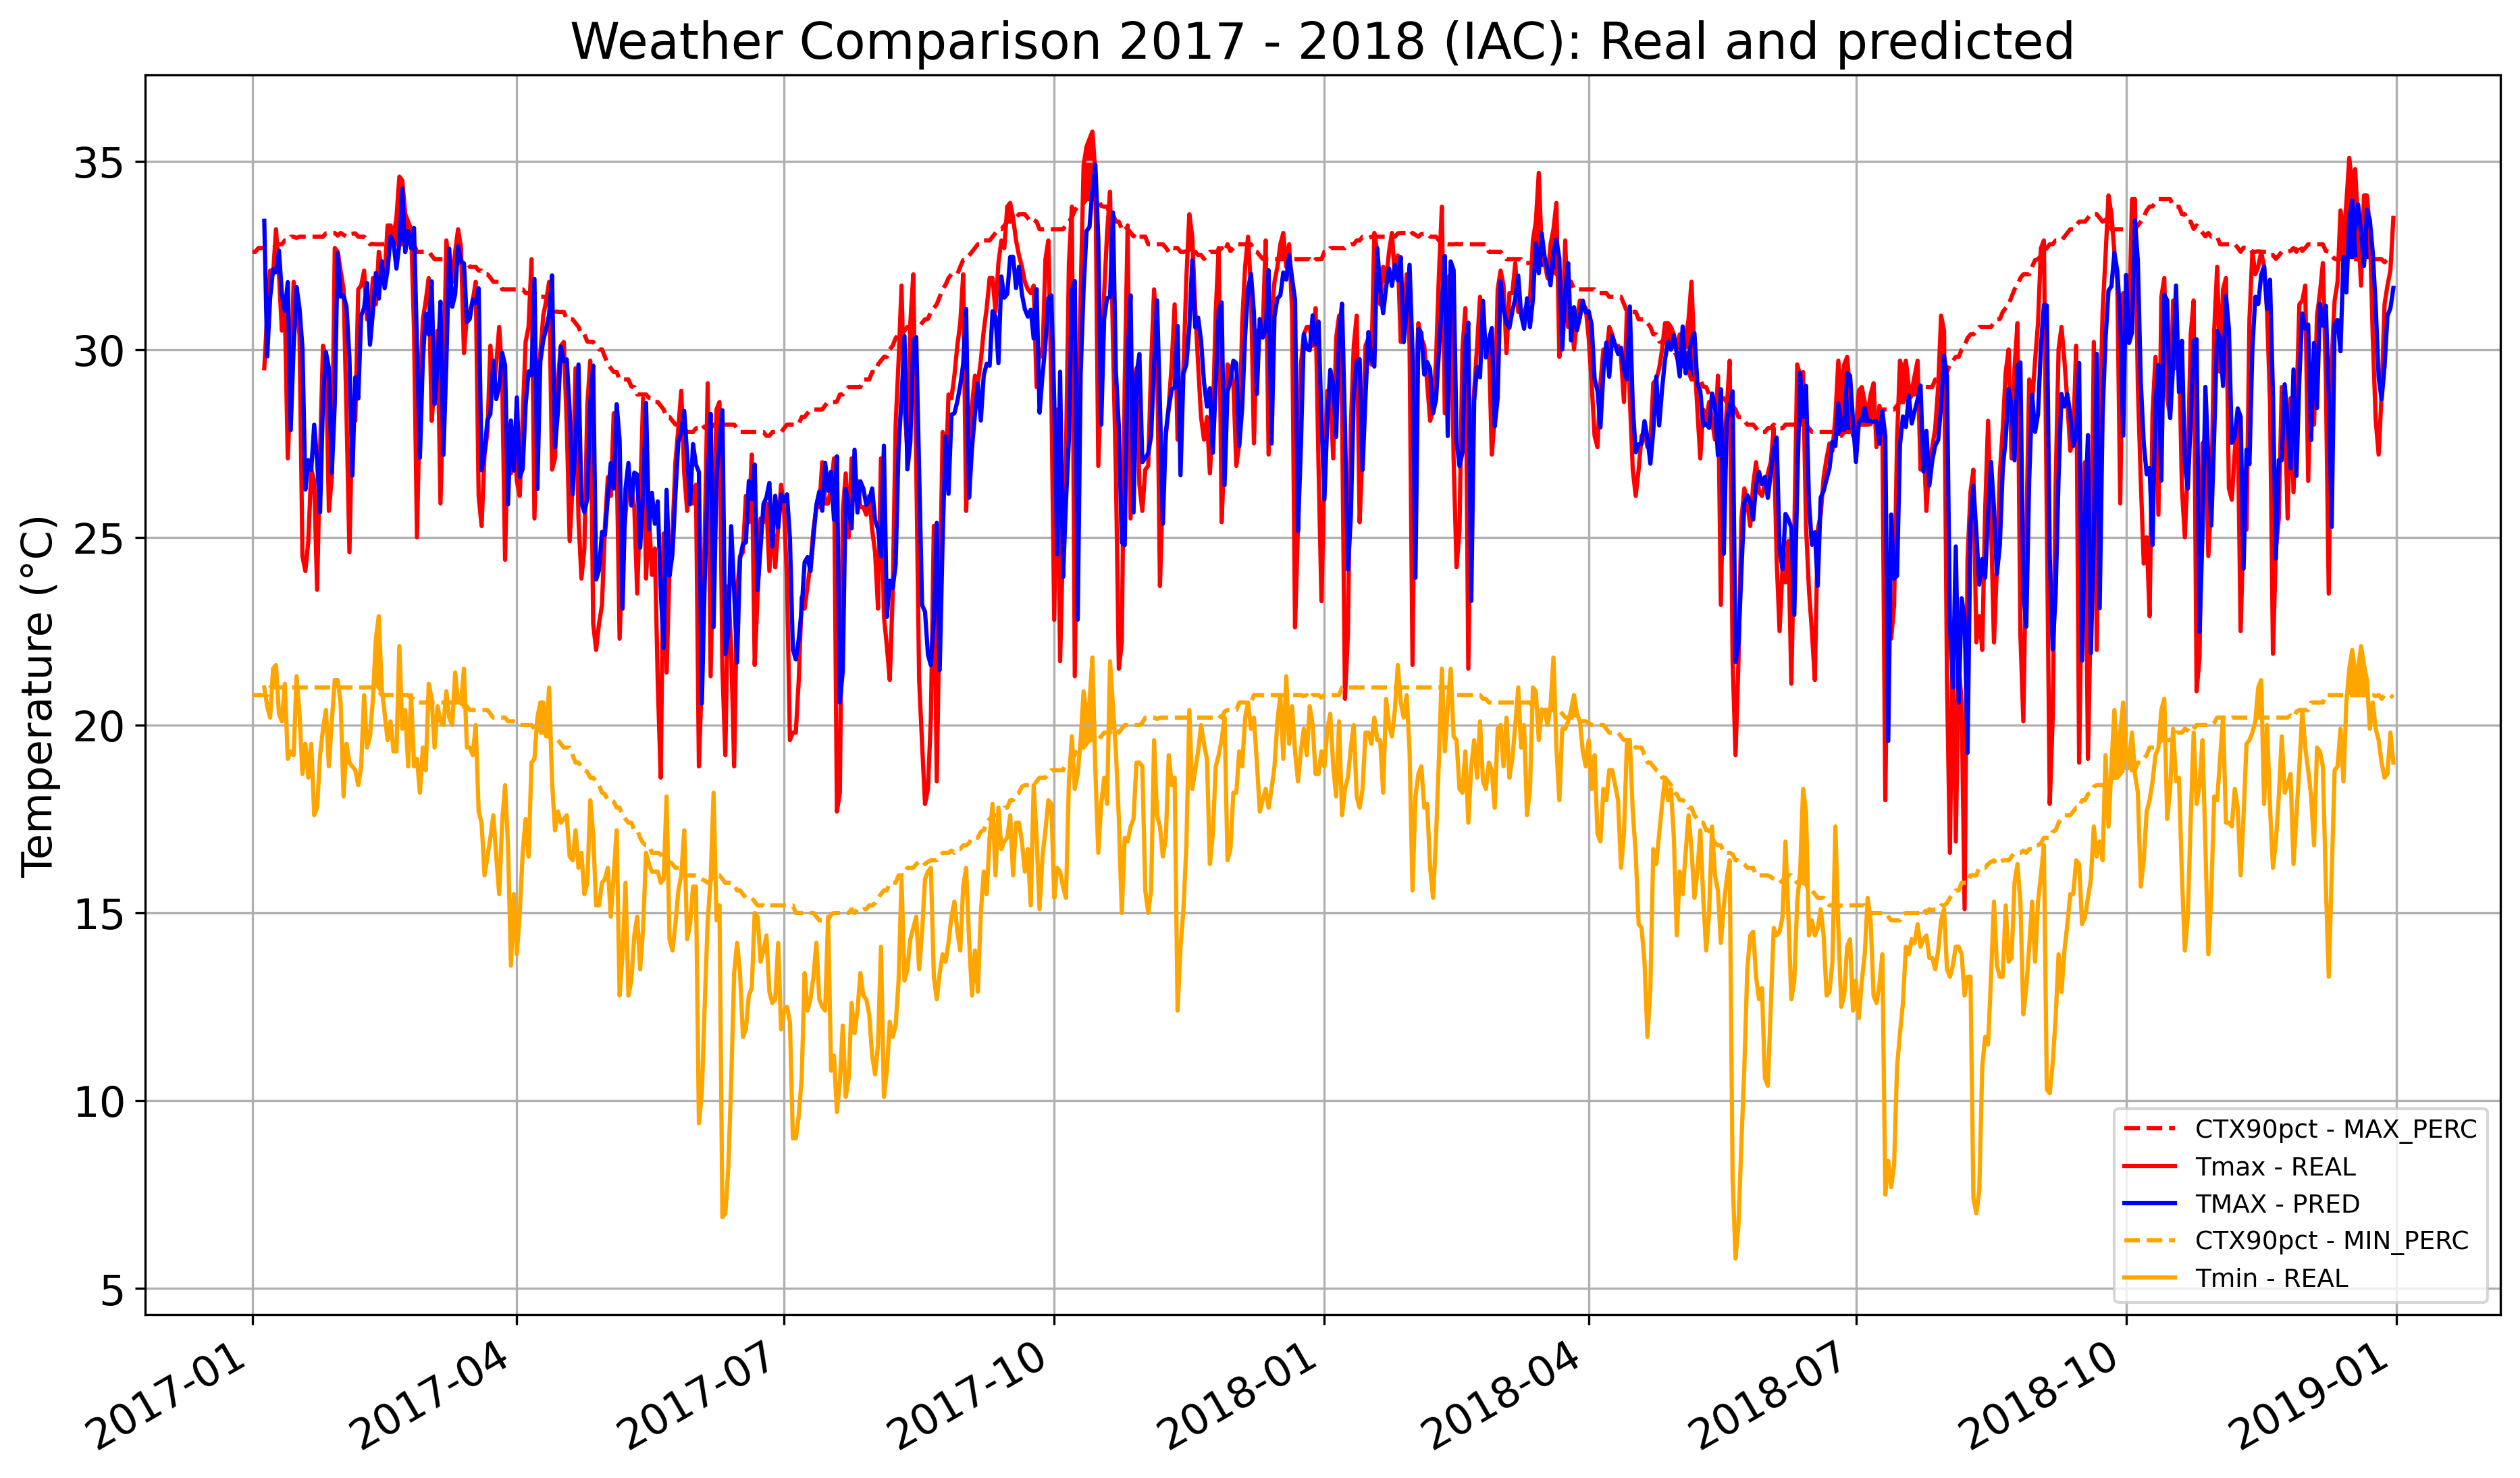

In [ ]:
#CTX90pct N_AIRTMP_MAX_real
plt.figure(figsize=(15,9),dpi=300)
plt.plot(pred_above_8_years['DATE'], pred_above_8_years['CMX90pct'],'--r',label='CTX90pct - MAX_PERC')
plt.plot(pred_above_8_years['DATE'], pred_above_8_years['N_AIRTMP_MAX'],'r',label='Tmax - REAL')
plt.fill_between(pred_above_8_years['DATE'], pred_above_8_years['CMX90pct'], pred_above_8_years['N_AIRTMP_MAX'], where = pred_above_8_years['CMX90pct'] <= pred_above_8_years['N_AIRTMP_MAX'], facecolor='red', interpolate=True)

#CTN90pct N_AIRTMP_MAX_pred
plt.plot(pred_above_8_years['DATE'], pred_above_8_years['max_pred'],'b',label='TMAX - PRED')
plt.fill_between(pred_above_8_years['DATE'], pred_above_8_years['CMX90pct'], pred_above_8_years['max_pred'], where = pred_above_8_years['CMX90pct'] <= pred_above_8_years['max_pred'], facecolor='blue', interpolate=True)


#CTX90pct N_AIRTMP_MIN_REAL
plt.plot(pred_above_8_years['DATE'], pred_above_8_years['CMN90pct'],'--',color='orange',label='CTX90pct - MIN_PERC')
plt.plot(pred_above_8_years['DATE'], pred_above_8_years['N_AIRTMP_MIN'],color='orange',label='Tmin - REAL')
plt.fill_between(pred_above_8_years['DATE'], pred_above_8_years['CMN90pct'], pred_above_8_years['N_AIRTMP_MIN'], where = pred_above['CMN90pct'] <= pred_above_8_years['N_AIRTMP_MIN'], facecolor='orange', interpolate=True)


#CTN90pct N_AIRTMP_MIN_PRED
#plt.plot(df_merge_col['DATE'], df_merge_col['min_pred'],color='gray',label='Tmin - PRED')
#plt.fill_between(df_merge_col['DATE'], df_merge_col['CMN90pct_x'], df_merge_col['min_pred'], where = df_merge_col['CMN90pct_x'] <= df_merge_col['min_pred'], facecolor='gray', interpolate=True)


plt.title('Weather Comparison 2017 - 2018 (IAC): Real and predicted',fontsize=18)
plt.ylabel('Temperature (°C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.autofmt_xdate()
plt.grid()
plt.legend(loc=4, prop={'size': 9})
plt.show()

##**LSTM one day ahead (4 Years)**

In [ ]:
df_one_day = df_one_day.iloc[365*4:]
df_one_day

N_RAIN_TOT  N_AIRTMP_MAX  N_AIRTMP_MIN  above_pct  y
DATE                                                            
2013-01-01        15.2          30.7          19.1          0  0
2013-01-02         0.5          31.6          20.4          0  0
2013-01-03         0.0          28.6          19.1          0  0
2013-01-04         0.0          28.3          20.1          0  0
2013-01-05        29.7          31.3          18.9          0  0
...                ...           ...           ...        ... ..
2018-12-27         0.0          28.8          19.0          0  0
2018-12-28        23.1          31.2          18.6          0  0
2018-12-29         0.0          31.7          18.7          0  0
2018-12-30         0.0          32.1          19.8          0  0
2018-12-31         0.0          33.5          19.0          0  0

[2190 rows x 5 columns]

##**Series to supervised (4 years)**

In [ ]:
#######     train one day ahead (4 years)      ############

n_train_days = 365 * 4 #2013 a 2016

df_train = df_one_day.iloc[:n_train_days, :]
df_train = df_train.drop(columns=['above_pct','y','N_RAIN_TOT'])
print(df_train.head(3))
values_train = df_train.values

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(values_train)
print(scaled_train[:5,:])
# specify the number of lag (1 line = 1 day)
n_days = 4
#DAYS_AHEAD = 1
days_ahead = 1
n_features = values_train.shape[1]

reframed_train = series_to_supervised(scaled_train, n_days, days_ahead)
train = reframed_train
print(train.head(5))
train = train.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2013-01-01          30.7          19.1
2013-01-02          31.6          20.4
2013-01-03          28.6          19.1
[[0.71428571 0.7020202 ]
 [0.7481203  0.76767677]
 [0.63533835 0.7020202 ]
 [0.62406015 0.75252525]
 [0.73684211 0.69191919]]
   var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t-1)   var1(t)   var2(t)
4   0.714286   0.702020   0.748120  ...   0.752525  0.736842  0.691919
5   0.748120   0.767677   0.635338  ...   0.691919  0.755639  0.787879
6   0.635338   0.702020   0.624060  ...   0.787879  0.736842  0.676768
7   0.624060   0.752525   0.736842  ...   0.676768  0.755639  0.787879
8   0.736842   0.691919   0.755639  ...   0.787879  0.650376  0.797980

[5 rows x 10 columns]


In [ ]:
#######     test one day ahead (4 years)      ############

df_test = df_one_day.iloc[n_train_days:, :]
df_test = df_test.drop(columns=['above_pct',	'y','N_RAIN_TOT'])
print(df_test)
values_test = df_test.values
# ensure all data is float
np.set_printoptions(suppress=True) #supress scientific notation
values_test = values_test.astype('float32')
# normalize features
scaled_test = scaler_train.transform(values_test)
print(scaled_test[:5,:])
print(scaled_test[-5:,:])
# specify the number of lag (days in this case, since each line equals a day)

n_features = values_test.shape[1]
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, n_days, days_ahead)
test = reframed_test
print(test)
test = test.values

            N_AIRTMP_MAX  N_AIRTMP_MIN
DATE                                  
2017-01-01          31.2          20.4
2017-01-02          31.8          19.9
2017-01-03          31.5          21.5
2017-01-04          34.5          21.0
2017-01-05          29.5          21.0
...                  ...           ...
2018-12-27          28.8          19.0
2018-12-28          31.2          18.6
2018-12-29          31.7          18.7
2018-12-30          32.1          19.8
2018-12-31          33.5          19.0

[730 rows x 2 columns]
[[0.7330828  0.7676767 ]
 [0.7556391  0.74242425]
 [0.7443609  0.8232323 ]
 [0.8571429  0.7979797 ]
 [0.6691729  0.7979797 ]]
[[0.6428571  0.6969697 ]
 [0.7330828  0.67676765]
 [0.7518797  0.6818182 ]
 [0.7669172  0.73737365]
 [0.81954885 0.6969697 ]]
     var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t-1)   var1(t)   var2(t)
4     0.733083   0.767677   0.755639  ...   0.797980  0.669173  0.797980
5     0.755639   0.742424   0.744361  ...   0.797980  0.721804  0.77272

In [ ]:
n_obs = n_days * n_features

#Train and test
train_X, train_y = train[:, :n_obs], train[:, -2]
test_X, test_y = test[:, :n_obs], test[:, -2]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input (train_X and test_X) to be 3D [SAMPLES, TIMESTEPS, FEATURES]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1456, 8) 1456 (1456,)
(1456, 4, 2) (1456,) (726, 4, 2) (726,)


Epoch 1/170
10/10 - 3s - loss: 0.2143 - val_loss: 0.0994
Epoch 2/170
10/10 - 0s - loss: 0.0504 - val_loss: 0.0142
Epoch 3/170
10/10 - 0s - loss: 0.0163 - val_loss: 0.0145
Epoch 4/170
10/10 - 0s - loss: 0.0159 - val_loss: 0.0136
Epoch 5/170
10/10 - 0s - loss: 0.0155 - val_loss: 0.0135
Epoch 6/170
10/10 - 0s - loss: 0.0154 - val_loss: 0.0134
Epoch 7/170
10/10 - 0s - loss: 0.0153 - val_loss: 0.0133
Epoch 8/170
10/10 - 0s - loss: 0.0152 - val_loss: 0.0132
Epoch 9/170
10/10 - 0s - loss: 0.0151 - val_loss: 0.0132
Epoch 10/170
10/10 - 0s - loss: 0.0151 - val_loss: 0.0131
Epoch 11/170
10/10 - 0s - loss: 0.0150 - val_loss: 0.0130
Epoch 12/170
10/10 - 0s - loss: 0.0149 - val_loss: 0.0130
Epoch 13/170
10/10 - 0s - loss: 0.0148 - val_loss: 0.0129
Epoch 14/170
10/10 - 0s - loss: 0.0148 - val_loss: 0.0129
Epoch 15/170
10/10 - 0s - loss: 0.0147 - val_loss: 0.0128
Epoch 16/170
10/10 - 0s - loss: 0.0147 - val_loss: 0.0128
Epoch 17/170
10/10 - 0s - loss: 0.0146 - val_loss: 0.0127
Epoch 18/170
10/10 - 0s

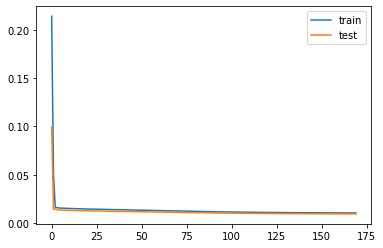

In [ ]:
#ORIGINAL

# design network
model = Sequential()
model.add(LSTM(70,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='nadam')

# fit network
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', patience=170,verbose=0)
callbacks_list = [stop]

history = model.fit(train_X, train_y, epochs=170, batch_size=150, callbacks = callbacks_list, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat1 = model.predict(test_X)
#Reshape test_X to get 7 random columns
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

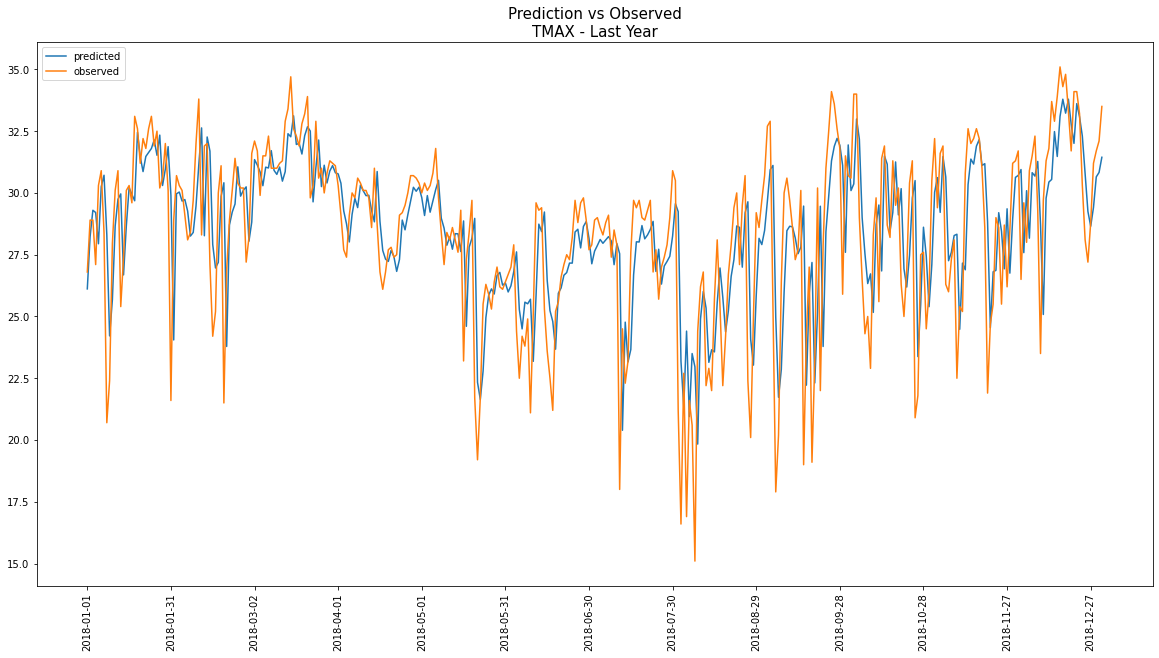

In [ ]:
inv_param = -1*(n_features-1)
# invert scaling for forecast
inv_yhat1 = concatenate((yhat1, test_X[:, inv_param:]), axis=1)
inv_yhat1 = scaler_train.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]



test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, inv_param:]), axis=1)
inv_y = scaler_train.inverse_transform(inv_y)
inv_y = inv_y[:,0]


# plot time series
ts_size = 365 #how many days from the end do you wanna see?
interval = 30 #days invterval for x ticks

plt.figure(figsize=[20,10])
plt.plot(inv_yhat1[-ts_size:], label='predicted')
plt.plot(inv_y[-ts_size:], label='observed')
plt.title('Prediction vs Observed\nTMAX - Last Year',fontsize=15)
dates = df.index[-ts_size:-1].date
ticks = []
for i in list(range(0,len(dates),interval)):
  ticks.append(dates[i])
plt.xticks(range(0, ts_size,interval),ticks,rotation=90)
plt.legend()
plt.show()

In [ ]:
rmse_4_years = np.sqrt(mean_squared_error(inv_y, inv_yhat1))
print(model.summary(),'\n')
print('n atrasos = ',n_days,'dias')
print('Test RMSE: %.3f' % rmse_4_years)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 70)                20440     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 71        
Total params: 20,511
Trainable params: 20,511
Non-trainable params: 0
_________________________________________________________________
None 

n atrasos =  4 dias
Test RMSE: 2.571


##**Results LSTM 4 years one day ahead**

In [ ]:
#Create a new data frane for max_pred
temp_pred_4_years = pd.DataFrame()
temp_pred_4_years['max_pred'] = inv_yhat1
temp_pred_4_years
temp_pred_4_years['DATE'] = df_one_day.index[n_train_days + n_days :]
df_merge_col_4_years = pd.merge(temp_pred_4_years, df, on='DATE')
df_merge_col_4_years = df_merge_col_4_years.drop(columns=['above_pct', 'y'])


#Climatex for temp_pred
#Using the same normal climatic and real temp min to check max_temp_pred performance
pred_above_4_years, df_pct_4_years = tex.check_HeatWave(df_merge_col_4_years, 'max_pred', 'N_AIRTMP_MAX', df_vir, 'N_AIRTMP_MAX', 'N_AIRTMP_MIN')
pred_above_4_years = pred_above_4_years.drop(columns=['N_RAIN_TOT'])
pred_above_4_years = pd.merge(pred_above_4_years, df_pct_4_years, on='DAY365')
pred_above_4_years = pred_above_4_years.sort_values(by='DATE')
pred_above_4_years.head(15)

DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
0        1 2017-01-01        NaN  ...   0     32.60      20.8
2        2 2017-01-02        NaN  ...   0     32.60      20.8
4        3 2017-01-03        NaN  ...   0     32.70      20.8
6        4 2017-01-04        NaN  ...   0     32.70      20.8
8        5 2017-01-05  33.417599  ...   0     32.70      20.8
10       6 2017-01-06  29.670732  ...   0     32.70      20.8
12       7 2017-01-07  31.434856  ...   0     32.70      21.0
14       8 2017-01-08  31.772448  ...   0     32.70      21.0
16       9 2017-01-09  31.768135  ...   0     32.77      21.0
18      10 2017-01-10  32.626621  ...   0     32.80      21.0
20      11 2017-01-11  31.429756  ...   0     32.80      21.0
22      12 2017-01-12  30.771389  ...   0     32.90      21.0
24      13 2017-01-13  31.488546  ...   0     32.90      21.0
26      14 2017-01-14  27.972065  ...   0     33.00      21.0
28      15 2017-01-15  29.978294  ...   0     33.00      21.0

[15 rows x 9 columns]

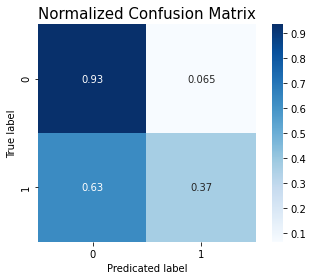

In [ ]:
cm_4_years = confusion_matrix(df_vir[df_vir['YEAR']>=2017]['above_pct'], pred_above_8_years['above_pct'],normalize='true')
sns.heatmap(cm_4_years, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix",fontsize = 15)
plt.xlabel("Predicated label")
plt.ylabel("True label")
plt.show()

In [ ]:
metrics_4_years = tex.wave_metrics(pred_above_4_years, 'HW', False)
metrics_4_years

HWN  HWD   HWF
YEAR                
2017  1.0  3.0   3.0
2018  6.0  5.0  21.0

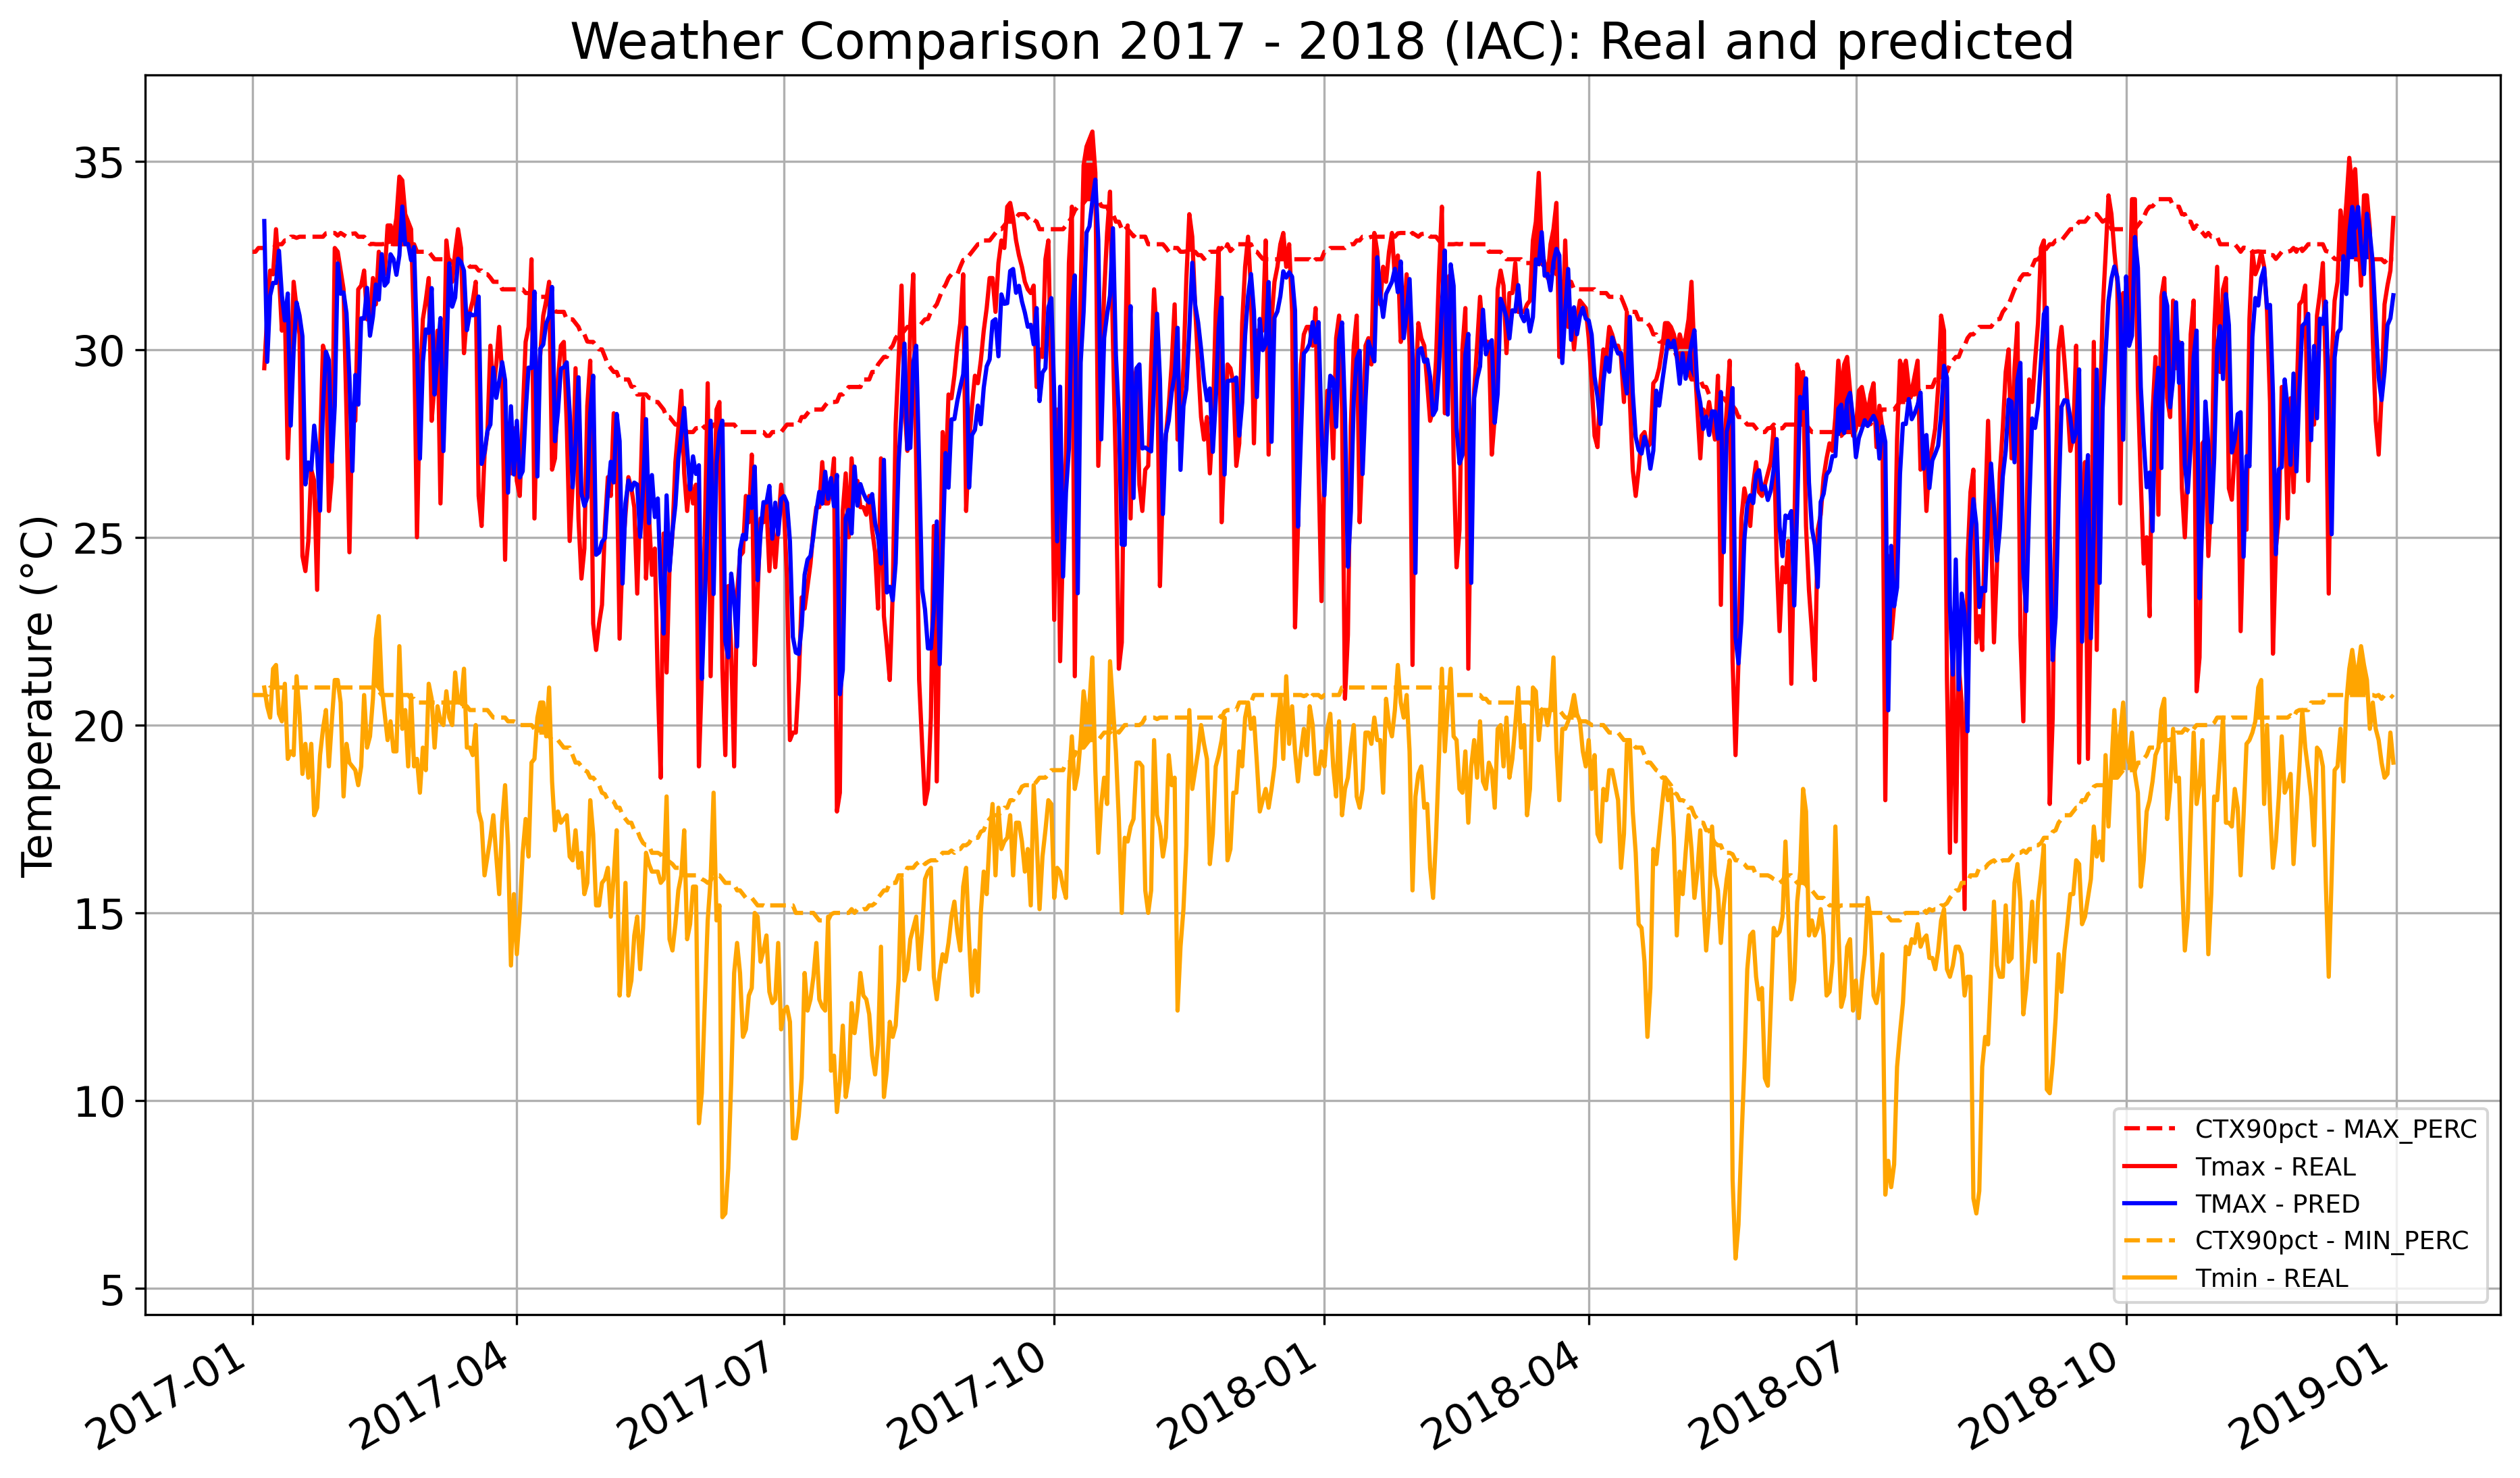

In [ ]:
#CTX90pct N_AIRTMP_MAX_real
plt.figure(figsize=(15,9),dpi=300)
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'],'--r',label='CTX90pct - MAX_PERC')
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['N_AIRTMP_MAX'],'r',label='Tmax - REAL')
plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'], pred_above_4_years['N_AIRTMP_MAX'], where = pred_above_4_years['CMX90pct'] <= pred_above_4_years['N_AIRTMP_MAX'], facecolor='red', interpolate=True)

#CTN90pct N_AIRTMP_MAX_pred
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['max_pred'],'b',label='TMAX - PRED')
plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'], pred_above_4_years['max_pred'], where = pred_above_4_years['CMX90pct'] <= pred_above_4_years['max_pred'], facecolor='blue', interpolate=True)


#CTX90pct N_AIRTMP_MIN_REAL
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['CMN90pct'],'--',color='orange',label='CTX90pct - MIN_PERC')
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['N_AIRTMP_MIN'],color='orange',label='Tmin - REAL')
plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMN90pct'], pred_above_4_years['N_AIRTMP_MIN'], where = pred_above['CMN90pct'] <= pred_above_4_years['N_AIRTMP_MIN'], facecolor='orange', interpolate=True)




plt.title('Weather Comparison 2017 - 2018 (IAC): Real and predicted',fontsize=18)
plt.ylabel('Temperature (°C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.autofmt_xdate()
plt.grid()
plt.legend(loc=4, prop={'size': 9})
plt.show()

##**Final results**

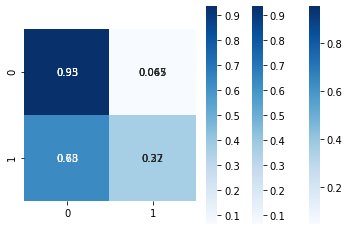

In [ ]:
sns.heatmap(cm_16_years, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
sns.heatmap(cm_8_years, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)
sns.heatmap(cm_4_years, square=True, annot=True,fmt='.2g',cmap=plt.cm.Blues)


In [ ]:

print('n atrasos = ',n_days,'dias')
print('Test RMSE 16 years model: %.3f' % rmse_16_years)


print('Test RMSE 8 years model: %.3f' % rmse_8_years)

print('Test RMSE 4 years model: %.3f' % rmse_4_years)

n atrasos =  4 dias
Test RMSE 16 years model: 2.572
Test RMSE 8 years model: 2.575
Test RMSE 4 years model: 2.571


In [ ]:
metrics_16_years

HWN  HWD   HWF
YEAR                
2017  0.0  0.0   0.0
2018  7.0  6.0  26.0

In [ ]:
metrics_8_years

HWN  HWD   HWF
YEAR                
2017  0.0  0.0   0.0
2018  7.0  6.0  28.0

In [ ]:
metrics_4_years

HWN  HWD   HWF
YEAR                
2017  1.0  3.0   3.0
2018  6.0  5.0  21.0

In [ ]:
sum(pred_above_16_years['max_pred'])


nan

##**Graph with predicts**

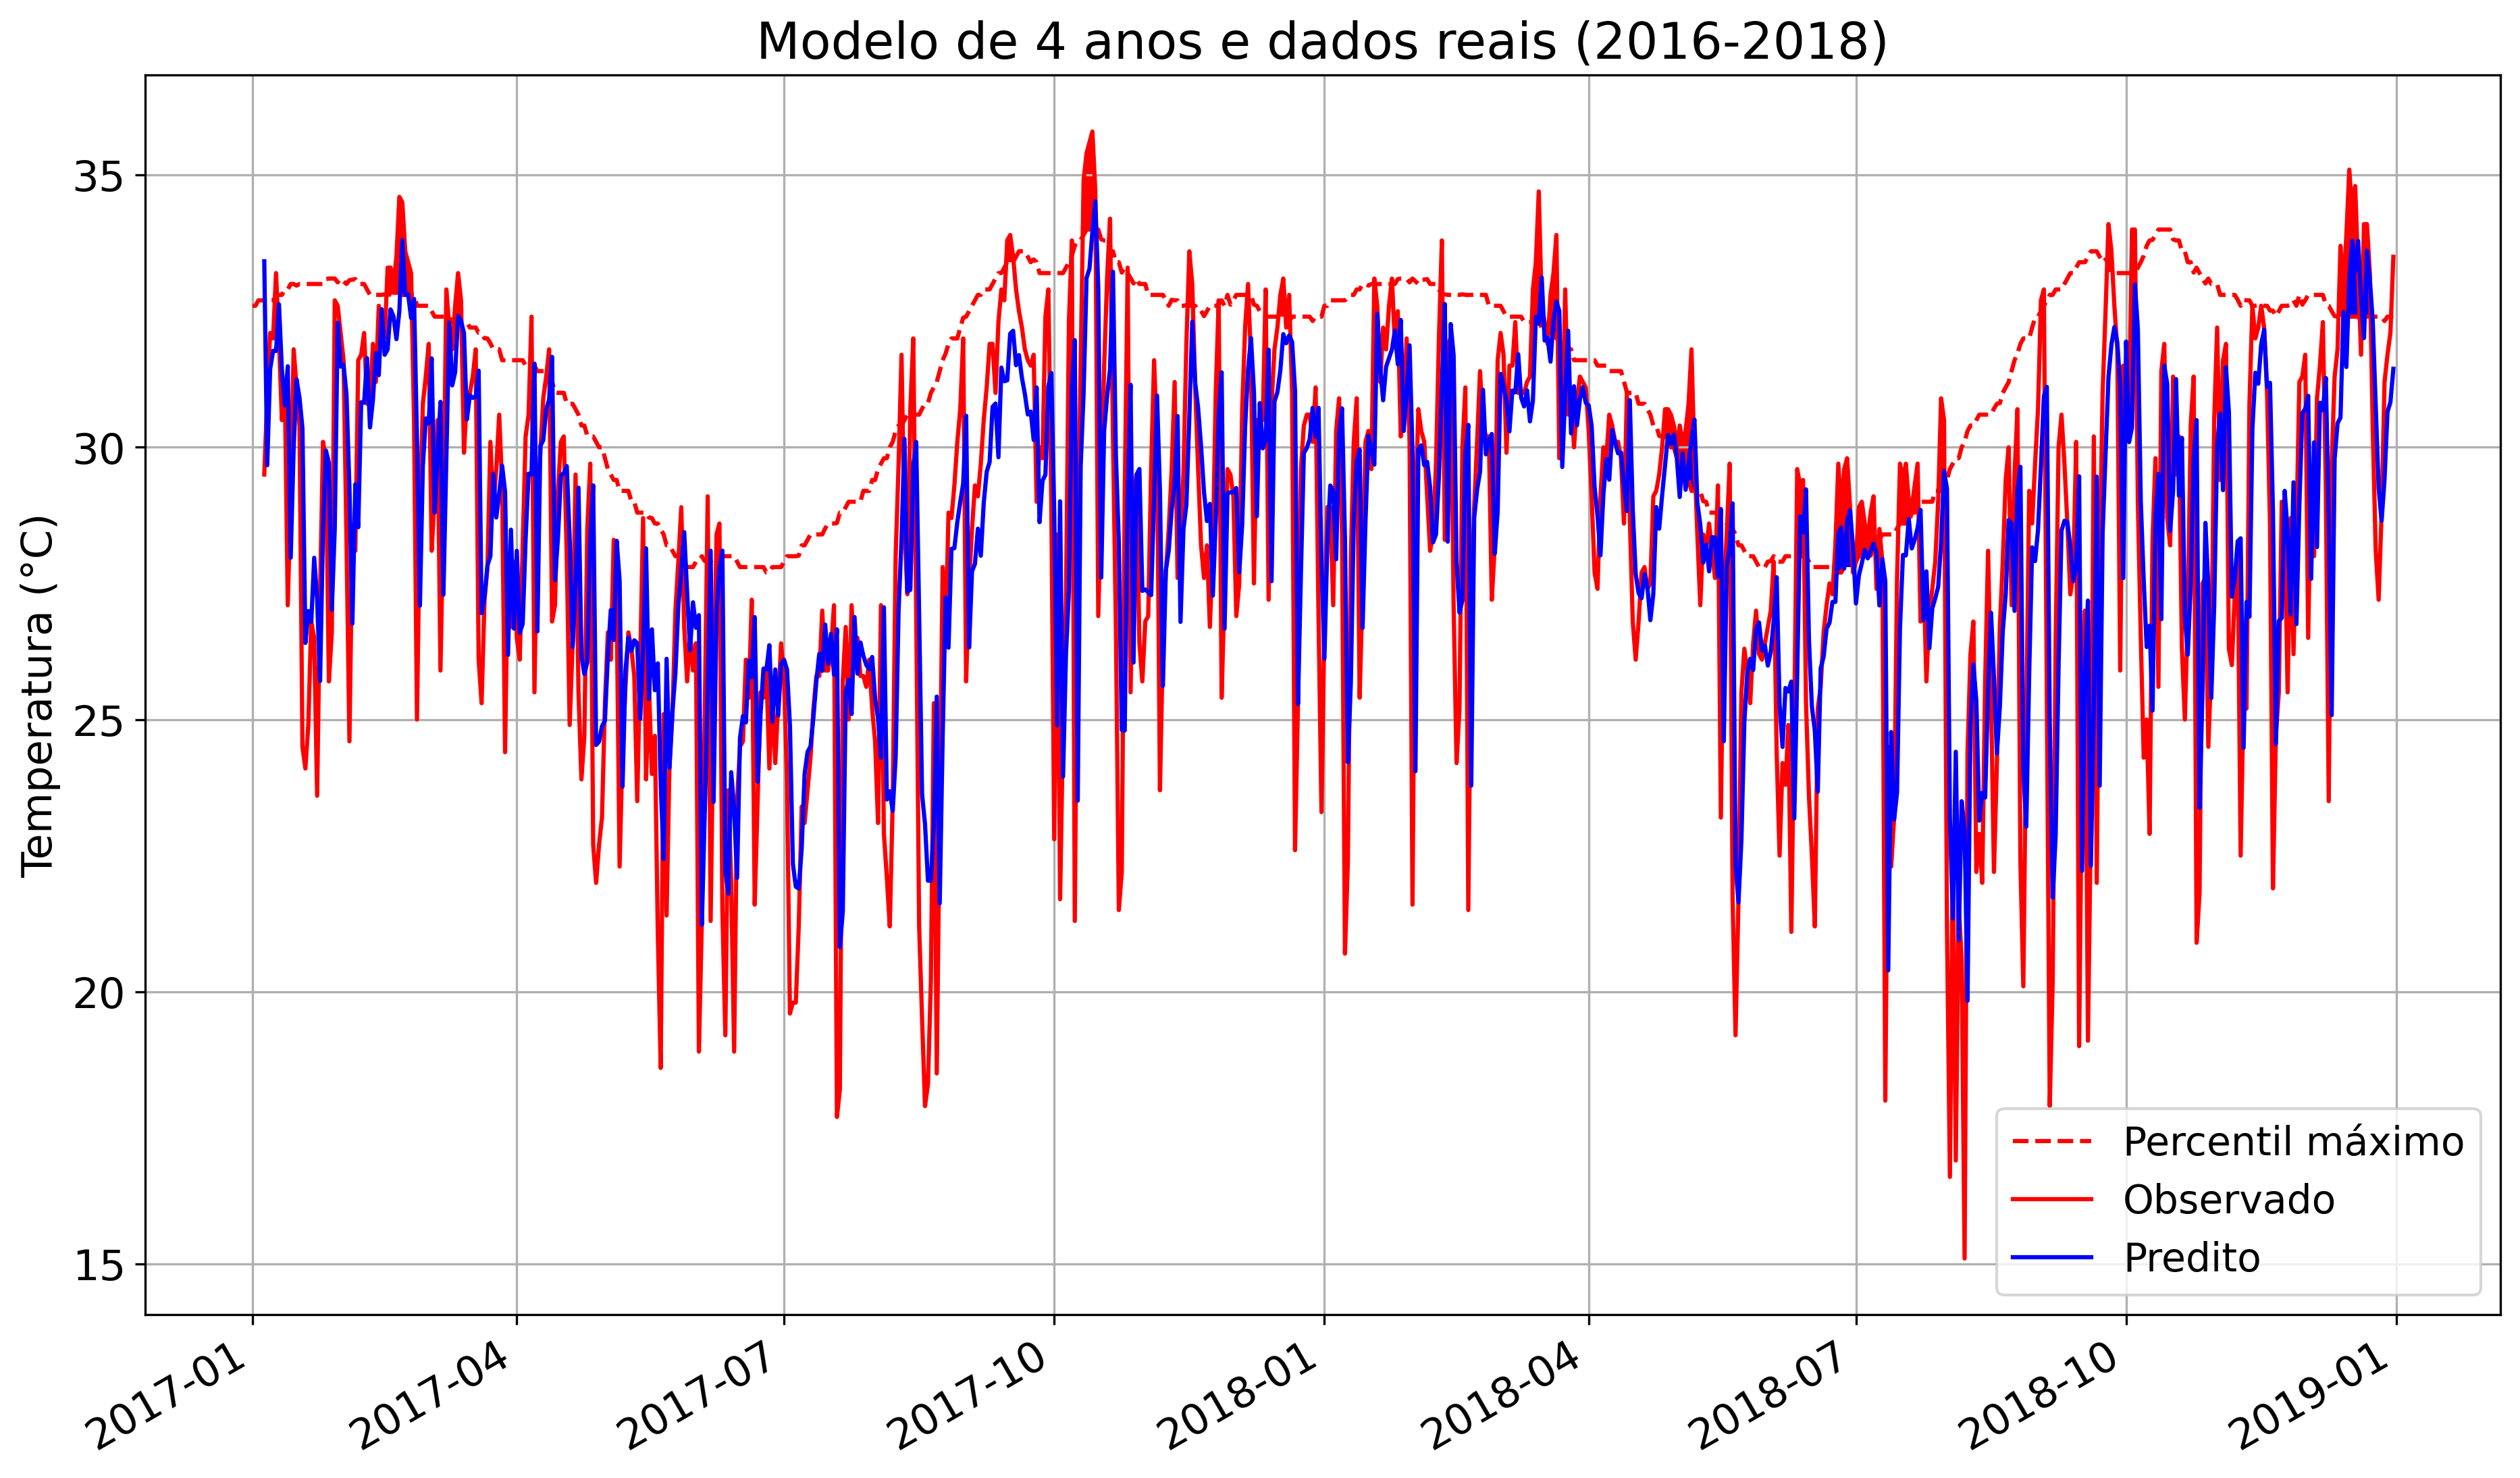

In [ ]:
#N_AIRTMP_MAX
plt.figure(figsize=(15,9),dpi=300)
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'],'--r',label='Percentil máximo')
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['N_AIRTMP_MAX'],'r',label='Observado')
plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'], pred_above_4_years['N_AIRTMP_MAX'], where = pred_above_4_years['CMX90pct'] <= pred_above_4_years['N_AIRTMP_MAX'], facecolor='red', interpolate=True)


#Max_pred
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['max_pred'],color='b',label='Predito')
plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'], pred_above_4_years['max_pred'], where = pred_above_4_years['CMX90pct'] <= pred_above_4_years['max_pred'], facecolor='b', interpolate=True)

plt.title('Modelo de 4 anos e dados reais (2016-2018)',fontsize=18)
plt.ylabel('Temperatura (°C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.autofmt_xdate()
plt.grid()
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [ ]:
#CTX90pct N_AIRTMP_MAX_real
plt.figure(figsize=(15,9),dpi=300)
#plt.plot(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'],'--r',label='CTX90pct - MAX_PERC')
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['max_pred'],'r',label='Tmax - pred (4 y model)')


#plt.plot(pred_above_8_years['DATE'], pred_above_8_years['max_pred'],'b',label='Tmax - pred (8 y model)')

#plt.plot(pred_above_16_years['DATE'], pred_above_16_years['max_pred'],'y',label='Tmax - pred (16 y model)')



#plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'], pred_above_4_years['N_AIRTMP_MAX'], where = pred_above_4_years['CMX90pct'] <= pred_above_4_years['N_AIRTMP_MAX'], facecolor='red', interpolate=True)




'''
#CTN90pct N_AIRTMP_MAX_pred
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['max_pred'],'b',label='TMAX - PRED')
plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMX90pct'], pred_above_4_years['max_pred'], where = pred_above_4_years['CMX90pct'] <= pred_above_4_years['max_pred'], facecolor='blue', interpolate=True)


#CTX90pct N_AIRTMP_MIN_REAL
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['CMN90pct'],'--',color='orange',label='CTX90pct - MIN_PERC')
plt.plot(pred_above_4_years['DATE'], pred_above_4_years['N_AIRTMP_MIN'],color='orange',label='Tmin - REAL')
plt.fill_between(pred_above_4_years['DATE'], pred_above_4_years['CMN90pct'], pred_above_4_years['N_AIRTMP_MIN'], where = pred_above['CMN90pct'] <= pred_above_4_years['N_AIRTMP_MIN'], facecolor='orange', interpolate=True)

'''


plt.title('Weather Comparison 2017 - 2018 (IAC): Real and predicted',fontsize=18)
plt.ylabel('Temperature (°C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig = plt.gcf()
fig.autofmt_xdate()
plt.grid()
plt.legend(loc=4, prop={'size': 9})
plt.show()

In [ ]:
pred_above_16_years

DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
0         1 2017-01-01        NaN  ...   0     32.60     20.80
2         2 2017-01-02        NaN  ...   0     32.60     20.80
4         3 2017-01-03        NaN  ...   0     32.70     20.80
6         4 2017-01-04        NaN  ...   0     32.70     20.80
8         5 2017-01-05  33.273232  ...   0     32.70     20.80
..      ...        ...        ...  ...  ..       ...       ...
721     361 2018-12-27  28.442373  ...   0     32.40     20.70
723     362 2018-12-28  29.436426  ...   0     32.32     20.80
725     363 2018-12-29  30.881525  ...   0     32.40     20.80
727     364 2018-12-30  31.034531  ...   0     32.40     20.80
729     365 2018-12-31  31.392212  ...   0     32.40     20.73

[730 rows x 9 columns]

In [ ]:
pred_above_4_years

DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
0         1 2017-01-01        NaN  ...   0     32.60     20.80
2         2 2017-01-02        NaN  ...   0     32.60     20.80
4         3 2017-01-03        NaN  ...   0     32.70     20.80
6         4 2017-01-04        NaN  ...   0     32.70     20.80
8         5 2017-01-05  33.417599  ...   0     32.70     20.80
..      ...        ...        ...  ...  ..       ...       ...
721     361 2018-12-27  28.651787  ...   0     32.40     20.70
723     362 2018-12-28  29.413473  ...   0     32.32     20.80
725     363 2018-12-29  30.649220  ...   0     32.40     20.80
727     364 2018-12-30  30.829712  ...   0     32.40     20.80
729     365 2018-12-31  31.442730  ...   0     32.40     20.73

[730 rows x 9 columns]

In [ ]:
mean_16 = sum(pred_above_16_years['max_pred'][4:])/ len(pred_above_16_years['max_pred'][4:])

mean_8 = sum(pred_above_8_years['max_pred'][4:])/len(pred_above_8_years['max_pred'][4:])

mean_4 = sum(pred_above_4_years['max_pred'][4:])/len(pred_above_4_years['max_pred'][4:])

print(mean_16)
print(mean_8)
print(mean_4)

print(max(pred_above_16_years['max_pred'][4:]))
print(max(pred_above_8_years['max_pred'][4:]))
print(max(pred_above_4_years['max_pred'][4:]))

#8_years model sound more alarmist

28.39350054612173
28.46562701348759
28.38871155625861
34.37681198120117
34.92213821411133
34.51974868774414


## *Hot days*

In [ ]:
df_check = df_vir[df_vir['YEAR']>=2017]
df_check

DAY365       DATE  YEAR  ...  N_AIRTMP_MIN  above_pct  HW
22265       1 2017-01-01  2017  ...          20.4          0   0
22266       2 2017-01-02  2017  ...          19.9          0   0
22267       3 2017-01-03  2017  ...          21.5          0   0
22268       4 2017-01-04  2017  ...          21.0          1   0
22269       5 2017-01-05  2017  ...          21.0          0   0
...       ...        ...   ...  ...           ...        ...  ..
22990     361 2018-12-27  2018  ...          19.0          0   0
22991     362 2018-12-28  2018  ...          18.6          0   0
22992     363 2018-12-29  2018  ...          18.7          0   0
22993     364 2018-12-30  2018  ...          19.8          0   0
22994     365 2018-12-31  2018  ...          19.0          0   0

[730 rows x 8 columns]

In [ ]:
hot_16 = sum(pred_above_16_years['above_pct'])
print(hot_16)

hot_8 = sum(pred_above_8_years['above_pct']) # More hot days
print(hot_8)

hot_4 = sum(pred_above_4_years['above_pct'])
print(hot_4)

hot_real = sum(df_check['above_pct'])
print(hot_real)

44
64
49
54


In [ ]:
hot_16 = sum(pred_above_16_years['HW'])
print(hot_16)

hot_8 = sum(pred_above_8_years['HW']) # More HW days
print(hot_8)

hot_4 = sum(pred_above_4_years['HW'])
print(hot_4)

hot_real = sum(df_check['HW'])
print(hot_real)

26
28
24
18


In [ ]:
print(sum(pred_above_16_years['max_pred'][4:])/len(pred_above_16_years['max_pred'][4:]))
print(sum(pred_above_8_years['max_pred'][4:])/len(pred_above_8_years['max_pred'][4:]))
print(sum(pred_above_4_years['max_pred'][4:])/len(pred_above_4_years['max_pred'][4:]))
print(sum(pred_above_8_years['N_AIRTMP_MAX'][4:])/len(pred_above_8_years['max_pred'][4:]))
print(sum(pred_above_16_years['N_AIRTMP_MAX'][4:])/len(pred_above_16_years['max_pred'][4:]))
print(sum(pred_above_4_years['N_AIRTMP_MAX'][4:])/len(pred_above_4_years['max_pred'][4:]))



28.39350054612173
28.46562701348759
28.38871155625861
28.21260709992128
28.21260709992128
28.21260709992128


In [ ]:
print(min(pred_above_16_years['max_pred'][4:]))
print(min(pred_above_8_years['max_pred'][4:]))
print(min(pred_above_4_years['max_pred'][4:]))
print(min(pred_above_4_years['N_AIRTMP_MAX'][4:]))
print(min(pred_above_8_years['N_AIRTMP_MAX'][4:]))
print(min(pred_above_16_years['N_AIRTMP_MAX'][4:]))


19.510208129882812
19.26129150390625
19.835439682006836
15.1
15.1
15.1


In [ ]:
print("Máximo do modelo com 16 anos =" ,max(pred_above_16_years['max_pred'][4:]))
print("Máximo do modelo com 8 anos =" , max(pred_above_8_years['max_pred'][4:]))
print("Máximo do modelo com 4 anos =" , max(pred_above_4_years['max_pred'][4:]))
print("Máximo observado =" , max(pred_above_4_years['N_AIRTMP_MAX'][4:]))
print(max(pred_above_8_years['N_AIRTMP_MAX'][4:]))
print(max(pred_above_16_years['N_AIRTMP_MAX'][4:]))


Máximo do modelo com 16 anos = 34.37681198120117
Máximo do modelo com 8 anos = 34.92213821411133
Máximo do modelo com 4 anos = 34.51974868774414
Máximo observado = 35.8
35.8
35.8


##RMSE

In [ ]:
pred_above_16_years


DAY365       DATE   max_pred  ...  HW  CMX90pct  CMN90pct
0         1 2017-01-01        NaN  ...   0     32.60     20.80
2         2 2017-01-02        NaN  ...   0     32.60     20.80
4         3 2017-01-03        NaN  ...   0     32.70     20.80
6         4 2017-01-04        NaN  ...   0     32.70     20.80
8         5 2017-01-05  33.273232  ...   0     32.70     20.80
..      ...        ...        ...  ...  ..       ...       ...
721     361 2018-12-27  28.442373  ...   0     32.40     20.70
723     362 2018-12-28  29.436426  ...   0     32.32     20.80
725     363 2018-12-29  30.881525  ...   0     32.40     20.80
727     364 2018-12-30  31.034531  ...   0     32.40     20.80
729     365 2018-12-31  31.392212  ...   0     32.40     20.73

[730 rows x 9 columns]

In [ ]:
rmse_16_aux = pred_above_16_years['max_pred'][4:] - pred_above_16_years['N_AIRTMP_MAX'][4:]
rmse_16_aux = rmse_16_aux**2
rmse_16 = sum(rmse_16_aux)/len(rmse_16_aux)

rmse_8_aux = pred_above_8_years['max_pred'][4:] - pred_above_8_years['N_AIRTMP_MAX'][4:]
rmse_8_aux = rmse_8_aux**2
rmse_8 = sum(rmse_8_aux)/len(rmse_8_aux)


rmse_4_aux = pred_above_4_years['max_pred'][4:] - pred_above_4_years['N_AIRTMP_MAX'][4:]
rmse_4_aux = rmse_4_aux**2
rmse_4 = sum(rmse_4_aux)/len(rmse_4_aux)




In [ ]:
print(math.sqrt(rmse_16))
print(math.sqrt(rmse_8))
print(math.sqrt(rmse_4))

2.572239961172836
2.575386320122626
2.5714171010885796


In [ ]:
print(statistics.pstdev(pred_above_16_years['max_pred'][4:]))
print(statistics.pstdev(pred_above_8_years['max_pred'][4:]))
print(statistics.pstdev(pred_above_4_years['max_pred'][4:]))




2.7271778743959887
2.8295006109306007
2.735921813081339


In [ ]:
print(statistics.pstdev(pred_above_16_years['N_AIRTMP_MAX'][4:]))
print(statistics.pstdev(pred_above_8_years['N_AIRTMP_MAX'][4:]))
print(statistics.pstdev(pred_above_4_years['N_AIRTMP_MAX'][4:]))


3.6753264393959086
3.6753264393959086
3.6753264393959086


In [ ]:
sum(pred_above_16_years['N_AIRTMP_MAX'] < 19.9574)

21

In [ ]:
sum(pred_above_16_years['N_AIRTMP_MAX'] > 34.577)

9